# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="./DataECG.png" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [1]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [19]:
# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureTest.shape)


Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 188) Taille du dataset de test ECG : (1000, 188)
Taille de la base d apprentissage Features : (4000, 156) Taille du dataset de test Features : (1000, 156)


In [115]:
label_name = ["battement normaux", "battement inconnus"," bat ect. ventriculaire", "bat. ect. supra", "battement de fusion"]

### Isolation des caractéristiques

In [18]:
# Isolation des caractéristiques

# Temporel
DataFeatureAppTemp = DataFeatureApp[:, :31]
DataFeatureTestTemp = DataFeatureTest[:, :31]

# Statistique
DataFeatureAppStat = DataFeatureApp[:, 31:45]
DataFeatureTestStat = DataFeatureTest[:, 31:45]

# Spectrale
DataFeatureAppSpec = DataFeatureApp[:, 45:156]
DataFeatureTestSpec = DataFeatureTest[:, 45:156]

print(DataFeatureAppTemp.shape)
print(DataFeatureTestTemp.shape)
print(DataFeatureAppStat.shape)
print(DataFeatureTestStat.shape)
print(DataFeatureAppSpec.shape)
print(DataFeatureTestSpec.shape)

(4000, 31)
(1000, 31)
(4000, 14)
(1000, 14)
(4000, 111)
(1000, 111)


## Vecteur médian des caractéristiques pour chaque classe

In [116]:
# Calculer le vecteur médian des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques avec numpy
unique_labels = np.unique(LabelF_train)
print("Classes uniques :", unique_labels)

for label in unique_labels:
  Data_App_Temp= DataFeatureApp[:,:32]
  # Filtrer les données pour la classe actuelle
  class_features = Data_App_Temp[np.array(LabelF_train) == label]
    # Calculer la médiane des caractéristiques pour cette classe
  class_median = np.median(class_features, axis=0)  # Utilisation de np.median()
  class_feature_medians[label] = class_median

# Afficher les résultats
#for label, median_vector in class_feature_medians.items():
   # print(f"Vecteur médian pour la classe {label} : {median_vector}")

Classes uniques : [0. 1. 2. 3. 4.]


# Chargement des variables issues *TSFEL*

In [3]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [116]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

In [257]:
def assign_winners(mylist):
    print(mylist)
    ### recuperer la valeur max de chaque list avec index
    max_values_with_indices = [(max(sublist), sublist.index(max(sublist))) for sublist in mylist]


    ### comparer les valeur max et leur index ; recommencer si deux index se telescope 
        ### => le plus faible doit recommencer et se comparer à tout le monde pour voir s'il gagne ou pas et ainsi de suite
    for i in range(len(max_values_with_indices)):
        for j in range(i + 1, len(max_values_with_indices)):
            if max_values_with_indices[i][1] == max_values_with_indices[j][1]:  # Même index
                print("on a des egalité")
                if max_values_with_indices[i][0] > max_values_with_indices[j][0]:
                    index_of = mylist[j].index( max_values_with_indices[j][0])
                    mylist[j][index_of] = 0 
                    print(f"Tuple {max_values_with_indices[i]} est plus grand que {max_values_with_indices[j]}")
                    max_values_with_indices = assign_winners(mylist)
                    
                else:
                    index_of = mylist[i].index( max_values_with_indices[i][0]) 
                    mylist[j][index_of] = 0
                    print(f"Tuple {max_values_with_indices[j]} est plus grand que {max_values_with_indices[i]}")
                    max_values_with_indices = assign_winners(mylist)
    return max_values_with_indices
    

## test my correspondance 
def count_elem(l1,l2,index):
    l1 = set(l1)
    l2 = set (l2)
    all_lists = [l1,l2]

    # Comparer chaque paire de listes
    for i in range(len(all_lists)):
        for j in range(i + 1, len(all_lists)):
            common_elements = all_lists[i].intersection(all_lists[j])
            L_count[index].append(len(common_elements))
    #print(f"element en commun {len(common_elements)}")
    return (len(common_elements))

def true_label(L_pred, y_train):
    index_lpred = []
    index_y_train = []
    match_L = []
    global L_count 
    L_count = [[] for _ in range(5)]
    
    ### recuperer les index de chaque  classes prédites  et classes veritables
    for i in range(0,5):
        index_lpred.append(np.where(L_pred == i)[0])
        index_y_train.append(np.where(y_train == i)[0])

### correspondances entre les index d'une classe A avec les index d'une classe B (plus grand nombre)
    ### parcourir chaque classe d'index et faire un compte de ce qui en ont le plus
    for i in range(0,5):
        for j in range(0,5):
            match_L.append(count_elem(index_lpred[i],index_y_train[j],i))
    #print(L_count)

    w = assign_winners(L_count)
    print(w)

### mettre les nouvelles classes
    for i, indices in enumerate(index_lpred):
        class_value = w[i][1]  # Récupère la 2ᵉ valeur du tuple
        for index in indices:
            L_pred[index] = class_value    
    return L_pred
            
            



[[19, 8, 89, 13, 97], [99, 32, 58, 193, 14], [4, 2, 36, 4, 1], [89, 147, 5, 0, 2], [5, 1, 4, 0, 78]]
on a des egalité
Tuple (97, 4) est plus grand que (78, 4)
[[19, 8, 89, 13, 97], [99, 32, 58, 193, 14], [4, 2, 36, 4, 1], [89, 147, 5, 0, 2], [5, 1, 4, 0, 0]]
[(97, 4), (193, 3), (36, 2), (147, 1), (5, 0)]


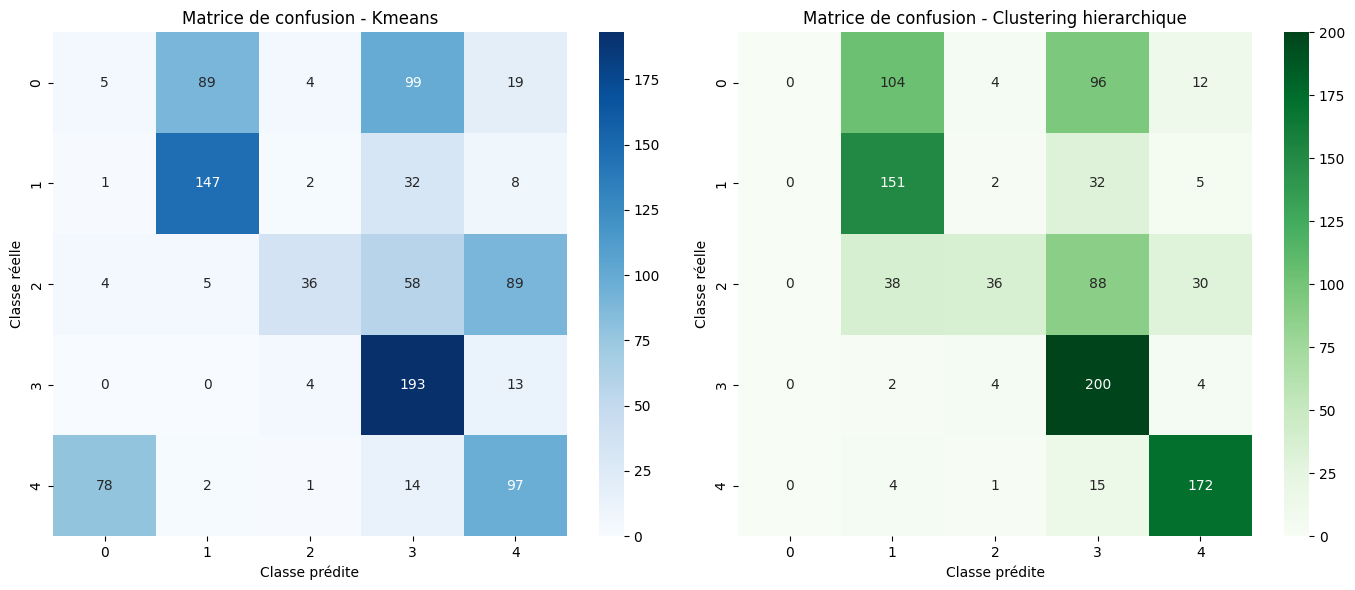

In [258]:
new_label = true_label(y_pred_km_all_T,LabelF_test)
conf_matrix_km_all_T = confusion_matrix(LabelF_test, new_label)
display_matrix(conf_matrix_km_all_T,conf_matrix_ch_all_T)

# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



information (alban) : On veut comparer les caracteristiques du jeu de test aux valeurs médianes (par exemple)   du jeu de test pour chaque classe ( car on sait a quel classe chaque battement appartient)

On a un ensemble de caracteristique par battement et on veut les comparér via l'algo DTW, celui dont on est le plus proche alors on peut le classer comme étant un battement de ce type la ( il faut comparer a chaque classe ).

In [6]:
from math import *
import sys

In [7]:
def DTW(A, B, d):
    """
    Algorithme DTW avec poids pour aligner deux séries temporelles.

    Args:
        A (list or np.ndarray): Première série temporelle.
        B (list or np.ndarray): Deuxième série temporelle.
        d (function): Fonction de distance locale entre deux points.

    Returns:
        float: Score d'alignement.
        list: Chemin optimal d'alignement.
    """
    # Définir les poids des transitions
    w0 = 1  # Poids pour l'insertion
    w1 = 2  # Poids pour la correspondance
    w2 = 1  # Poids pour la suppression

    N, M = len(A), len(B)

    # Initialisation de la matrice des coûts avec des valeurs infinies
    g = np.full((N + 1, M + 1), float('inf'))
    g[0, 0] = 0  # Point de départ

    # Initialisation des premières lignes et colonnes
    for j in range(1, M + 1):
        g[0, j] = float('inf')
    for i in range(1, N + 1):
        g[i, 0] = float('inf')

    # Remplissage de la matrice des coûts
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = d(A[i - 1], B[j - 1])
            g[i, j] = min(
                g[i - 1, j] + w0 * cost,     # Transition (i-1, j)
                g[i - 1, j - 1] + w1 * cost,  # Transition (i-1, j-1)
                g[i, j - 1] + w2 * cost      # Transition (i, j-1)
            )

    # Score d'alignement
    S = g[N, M] / (N + M)

    # Reconstruction du chemin optimal
    path = []
    i, j = N, M
    while i > 0 or j > 0:
        path.append((i - 1, j - 1))  # Convertir en index base 0
        if i > 0 and j > 0 and g[i, j] == g[i - 1, j - 1] + w1 * d(A[i - 1], B[j - 1]):
            i -= 1
            j -= 1
        elif i > 0 and g[i, j] == g[i - 1, j] + w0 * d(A[i - 1], B[j - 1]):
            i -= 1
        else:
            j -= 1

    path.reverse()  # Inverser le chemin pour qu'il soit dans l'ordre
    return S, path


## Système de reconnaissance de battements cardiaques par DTW



**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [8]:
# Calculer les vecteurs médians des caractéristiques pour chaque classe
class_feature_medians = {}

# Trouver les labels uniques
unique_labels = np.unique(LabelF_train)

for label in unique_labels:
    # Filtrer les données pour la classe actuelle
    class_features = DataFeatureApp[np.array(LabelF_train) == label]
    
    # Calculer la médiane des caractéristiques pour cette classe
    class_median = np.median(class_features, axis=0)
    class_feature_medians[label] = class_median

# Afficher les vecteurs médians pour chaque classe
for label, median in class_feature_medians.items():
    print(f"Classe {label} : Médiane calculée avec {len(median)} caractéristiques")


Classe 0.0 : Médiane calculée avec 156 caractéristiques
Classe 1.0 : Médiane calculée avec 156 caractéristiques
Classe 2.0 : Médiane calculée avec 156 caractéristiques
Classe 3.0 : Médiane calculée avec 156 caractéristiques
Classe 4.0 : Médiane calculée avec 156 caractéristiques


In [9]:
# Système de reconnaissance à partir de la DTW
#PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))

## à coder

In [10]:
# Taille du jeu de test
TAILLE_TEST = len(DataFeatureTest)

# Initialiser la partition avec deux colonnes : classe réelle et classe prédite
PartitionDTW = np.zeros((TAILLE_TEST, 2))

# Appliquer DTW pour chaque vecteur de test
for i, test_vector in enumerate(DataFeatureTest):
    best_score = float('inf')  # Initialiser le meilleur score à l'infini
    best_label = None  # Label correspondant au meilleur score
    best_path = None  # Chemin optimal correspondant au meilleur score

    for label, class_median in class_feature_medians.items():
        # Calcul du score DTW entre le vecteur de test et le vecteur médian de la classe
        score, path = DTW(test_vector, class_median, lambda x, y: abs(x - y))

        # Vérifier si c'est le meilleur score
        if score < best_score:
            best_score = score
            best_label = label
            best_path = path

    # Enregistrer la classe réelle et prédite dans PartitionDTW
    PartitionDTW[i, 0] = LabelF_test[i]  # Classe réelle
    PartitionDTW[i, 1] = best_label  # Classe prédite

    # Afficher le score et le chemin pour l'instance actuelle
    #print(f"Vecteur de test {i + 1} : Meilleur score = {best_score:.4f}, Classe prédite = {best_label}, Chemin = {best_path}")


Vecteur de test 13 : Meilleur score = 2.3989, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (42, 44), (43, 45), (44, 45), (45, 45), (46, 46), (46, 47), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77)

Vecteur de test 17 : Meilleur score = 2.5186, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (30, 32), (31, 32), (32, 33), (33, 33), (34, 33), (35, 33), (36, 34), (36, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 40), (41, 41), (41, 42), (42, 43), (43, 43), (44, 43), (45, 43), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79,

Vecteur de test 21 : Meilleur score = 1.9191, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (40, 38), (40, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (47, 44), (48, 44), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76,

Vecteur de test 25 : Meilleur score = 8.7597, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (41, 41), (42, 41), (42, 42), (43, 43), (43, 44), (44, 45), (44, 46), (45, 47), (46, 47), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (8

Vecteur de test 29 : Meilleur score = 7.4145, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 31), (33, 31), (34, 31), (35, 31), (35, 32), (35, 33), (35, 34), (36, 35), (36, 36), (37, 36), (37, 37), (37, 38), (37, 39), (38, 40), (39, 40), (40, 41), (40, 42), (41, 43), (42, 43), (43, 43), (44, 43), (45, 44), (45, 45), (45, 46), (45, 47), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (8

Vecteur de test 33 : Meilleur score = 8.4825, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (38, 36), (39, 37), (40, 37), (41, 37), (41, 38), (42, 39), (43, 39), (44, 39), (45, 39), (45, 40), (46, 40), (47, 41), (47, 42), (48, 43), (48, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75,

Vecteur de test 37 : Meilleur score = 3.6169, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 43), (44, 43), (45, 44), (45, 45), (45, 46), (46, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 8

Vecteur de test 43 : Meilleur score = 2.9920, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (42, 39), (42, 40), (42, 41), (43, 42), (43, 43), (44, 43), (45, 44), (46, 44), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75,

Vecteur de test 47 : Meilleur score = 2.2598, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (44, 44), (45, 45), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 8

Vecteur de test 53 : Meilleur score = 1.8123, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 38), (42, 39), (42, 40), (43, 40), (44, 41), (44, 42), (45, 42), (46, 42), (47, 43), (47, 44), (47, 45), (47, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (77, 76), (77, 77), (78, 78), (79,

Vecteur de test 58 : Meilleur score = 1.8484, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (33, 33), (34, 34), (35, 34), (36, 35), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 43), (45, 44), (45, 45), (46, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (8

Vecteur de test 62 : Meilleur score = 2.4804, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (38, 39), (38, 40), (38, 41), (39, 42), (40, 43), (41, 43), (42, 43), (43, 43), (44, 43), (45, 43), (46, 43), (47, 43), (48, 44), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (7

Vecteur de test 66 : Meilleur score = 2.6321, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 30), (32, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 39), (40, 40), (41, 40), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 46), (45, 46), (46, 46), (47, 47), (48, 47), (48, 48), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74,

Vecteur de test 70 : Meilleur score = 3.9563, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (39, 36), (39, 37), (40, 37), (41, 37), (42, 37), (43, 37), (44, 37), (45, 37), (46, 37), (47, 38), (48, 39), (48, 40), (48, 41), (48, 42), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (7

Vecteur de test 74 : Meilleur score = 1.6658, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (35, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (43, 38), (44, 38), (45, 38), (46, 38), (46, 39), (46, 40), (46, 41), (46, 42), (47, 43), (47, 44), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (7

Vecteur de test 78 : Meilleur score = 1.2333, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 39), (42, 40), (43, 40), (44, 41), (45, 41), (46, 41), (47, 42), (47, 43), (47, 44), (47, 45), (47, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (8

Vecteur de test 82 : Meilleur score = 3.1596, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (33, 33), (34, 33), (34, 34), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 43), (44, 44), (44, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 85), (87,

Vecteur de test 86 : Meilleur score = 2.7965, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (33, 33), (34, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 44), (44, 44), (45, 45), (46, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (8

Vecteur de test 90 : Meilleur score = 1.6422, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 42), (45, 43), (45, 44), (46, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76,

Vecteur de test 94 : Meilleur score = 4.3967, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (32, 32), (33, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 43), (44, 43), (45, 43), (46, 44), (47, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (8

Vecteur de test 98 : Meilleur score = 2.9700, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 86), (88, 87), (89, 88), (9

Vecteur de test 102 : Meilleur score = 1.8843, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 22), (24, 22), (25, 23), (26, 24), (27, 25), (28, 26), (29, 27), (30, 27), (31, 27), (31, 28), (31, 29), (32, 30), (33, 30), (33, 31), (34, 31), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 39), (39, 40), (40, 40), (41, 40), (42, 40), (43, 41), (43, 42), (43, 43), (43, 44), (43, 45), (44, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (

Vecteur de test 106 : Meilleur score = 14.1284, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (36, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 46), (43, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (7

Vecteur de test 110 : Meilleur score = 5.5739, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (35, 35), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 42), (39, 42), (40, 42), (41, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 47), (45, 47), (46, 48), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (

Vecteur de test 114 : Meilleur score = 14.5696, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (26, 27), (26, 28), (27, 29), (28, 29), (29, 30), (29, 31), (29, 32), (29, 33), (30, 33), (31, 33), (32, 33), (33, 33), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 46), (43, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (58, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), 

Vecteur de test 118 : Meilleur score = 2.1425, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (43, 44), (44, 44), (45, 44), (46, 44), (47, 44), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64

Vecteur de test 122 : Meilleur score = 1.3814, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 43), (43, 44), (44, 44), (45, 45), (45, 46), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (

Vecteur de test 126 : Meilleur score = 9.5631, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 35), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (38, 42), (39, 42), (40, 42), (41, 43), (41, 44), (42, 45), (42, 46), (43, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (

Vecteur de test 130 : Meilleur score = 4.1382, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 42), (46, 42), (47, 42), (48, 43), (48, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 

Vecteur de test 134 : Meilleur score = 1.5151, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 43), (44, 43), (44, 44), (45, 45), (45, 46), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 138 : Meilleur score = 1.7103, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (33, 31), (33, 32), (33, 33), (34, 34), (35, 35), (36, 35), (36, 36), (37, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (39, 42), (40, 42), (40, 43), (41, 44), (42, 45), (43, 45), (44, 45), (44, 46), (44, 47), (44, 48), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (

Vecteur de test 142 : Meilleur score = 2.0971, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 42), (44, 43), (44, 44), (44, 45), (45, 45), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (

Vecteur de test 146 : Meilleur score = 1.6278, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (44, 44), (45, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (

Vecteur de test 150 : Meilleur score = 3.6141, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (32, 31), (33, 31), (34, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (38, 39), (39, 40), (40, 41), (40, 42), (40, 43), (40, 44), (40, 45), (40, 46), (40, 47), (41, 47), (42, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 154 : Meilleur score = 11.6891, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (42, 43), (42, 44), (43, 45), (43, 46), (43, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), 

Vecteur de test 158 : Meilleur score = 2.7737, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (35, 30), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (38, 36), (39, 36), (40, 36), (40, 37), (41, 38), (41, 39), (41, 40), (42, 41), (43, 41), (43, 42), (44, 42), (45, 43), (46, 43), (47, 44), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72

Vecteur de test 162 : Meilleur score = 3.8951, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 44), (45, 45), (45, 46), (46, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 

Vecteur de test 166 : Meilleur score = 10.7563, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 39), (39, 39), (40, 39), (41, 39), (42, 39), (43, 40), (44, 41), (45, 41), (46, 41), (47, 41), (48, 41), (48, 42), (49, 43), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (50, 48), (50, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74,

Vecteur de test 170 : Meilleur score = 2.6209, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 39), (41, 40), (42, 40), (43, 40), (44, 40), (45, 40), (45, 41), (45, 42), (46, 42), (47, 42), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 174 : Meilleur score = 2.7950, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (37, 37), (38, 37), (39, 37), (40, 38), (41, 38), (42, 38), (43, 39), (43, 40), (44, 41), (45, 41), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 

Vecteur de test 178 : Meilleur score = 1.2633, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 42), (45, 43), (45, 44), (46, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 182 : Meilleur score = 2.8383, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (21, 23), (21, 24), (22, 25), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (30, 32), (31, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 35), (36, 35), (37, 35), (38, 36), (38, 37), (38, 38), (38, 39), (39, 39), (40, 39), (41, 39), (42, 40), (42, 41), (42, 42), (42, 43), (42, 44), (43, 44), (44, 44), (45, 44), (46, 44), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (52, 55), (52, 56), (53, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 186 : Meilleur score = 1.5504, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (32, 31), (32, 32), (33, 33), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (43, 39), (43, 40), (44, 40), (45, 41), (45, 42), (45, 43), (45, 44), (46, 45), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (

Vecteur de test 190 : Meilleur score = 1.2299, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 31), (35, 32), (35, 33), (35, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (44, 44), (45, 45), (46, 46), (47, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 194 : Meilleur score = 2.5137, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (37, 36), (38, 36), (39, 36), (40, 36), (41, 37), (42, 37), (43, 37), (44, 37), (45, 37), (45, 38), (45, 39), (45, 40), (45, 41), (46, 42), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (

Vecteur de test 198 : Meilleur score = 6.9493, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 28), (28, 28), (29, 28), (30, 29), (31, 29), (32, 30), (32, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (46, 40), (46, 41), (46, 42), (47, 42), (48, 42), (49, 43), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (50, 48), (50, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (

Vecteur de test 202 : Meilleur score = 10.7388, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 4), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 31), (31, 32), (31, 33), (31, 34), (32, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (43, 44), (44, 45), (44, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 59), (58, 60), (59, 61), (60, 62), (61, 63), (62, 63), (63, 63), (64, 64), (65, 64), (66, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75,

Vecteur de test 206 : Meilleur score = 2.7871, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (24, 22), (25, 23), (26, 24), (27, 25), (27, 26), (27, 27), (27, 28), (28, 28), (29, 28), (30, 29), (31, 30), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 40), (38, 40), (39, 40), (40, 41), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 41), (47, 41), (47, 42), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66

Vecteur de test 210 : Meilleur score = 4.1539, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 37), (39, 38), (40, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 41), (47, 42), (48, 42), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 

Vecteur de test 214 : Meilleur score = 3.8639, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 41), (41, 41), (42, 42), (43, 42), (44, 42), (45, 42), (45, 43), (46, 43), (47, 43), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 

Vecteur de test 218 : Meilleur score = 2.7876, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 20), (22, 21), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (34, 31), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (42, 46), (42, 47), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (

Vecteur de test 222 : Meilleur score = 1.9120, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 42), (44, 42), (45, 42), (45, 43), (45, 44), (46, 45), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77

Vecteur de test 226 : Meilleur score = 2.0726, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 41), (39, 41), (40, 41), (41, 41), (42, 42), (43, 42), (44, 42), (45, 42), (45, 43), (46, 43), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 

Vecteur de test 230 : Meilleur score = 18.6755, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (3, 5), (3, 6), (4, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 28), (28, 28), (29, 28), (30, 29), (31, 29), (32, 30), (33, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 42), (38, 43), (39, 43), (40, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 48), (45, 48), (46, 48), (47, 48), (47, 49), (48, 49), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), 

Vecteur de test 234 : Meilleur score = 7.2242, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 18), (20, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (30, 32), (30, 33), (31, 33), (32, 33), (33, 33), (34, 33), (35, 33), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (38, 37), (38, 38), (39, 39), (40, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 44), (45, 45), (45, 46), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (52, 55), (53, 56), (53, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (

Vecteur de test 238 : Meilleur score = 2.2172, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (39, 38), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 43), (46, 43), (47, 43), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 

Vecteur de test 242 : Meilleur score = 2.0509, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (31, 33), (32, 33), (33, 33), (34, 33), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 85), (

Vecteur de test 246 : Meilleur score = 4.6957, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (25, 23), (26, 24), (27, 25), (28, 26), (28, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (43, 44), (43, 45), (43, 46), (43, 47), (44, 48), (44, 49), (44, 50), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71

Vecteur de test 250 : Meilleur score = 2.3334, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (38, 37), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (45, 40), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (

Vecteur de test 254 : Meilleur score = 6.0232, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (31, 33), (32, 33), (33, 33), (34, 33), (35, 33), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (38, 36), (39, 37), (40, 37), (41, 38), (42, 39), (42, 40), (43, 40), (43, 41), (43, 42), (43, 43), (43, 44), (43, 45), (43, 46), (43, 47), (44, 47), (45, 47), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78

Vecteur de test 258 : Meilleur score = 19.7896, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 4), (38, 4), (38, 5), (39, 6), (40, 7), (41, 7), (42, 8), (42, 9), (42, 10), (42, 11), (42, 12), (42, 13), (42, 14), (42, 15), (42, 16), (42, 17), (42, 18), (42, 19), (42, 20), (42, 21), (42, 22), (42, 23), (42, 24), (42, 25), (42, 26), (42, 27), (42, 28), (42, 29), (42, 30), (42, 31), (42, 32), (42, 33), (42, 34), (42, 35), (42, 36), (42, 37), (42, 38), (42, 39), (42, 40), (42, 41), (42, 42), (42, 43), (42, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56

Vecteur de test 262 : Meilleur score = 7.8160, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 18), (20, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (36, 35), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (41, 41), (42, 42), (42, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (52, 55), (53, 56), (53, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (

Vecteur de test 266 : Meilleur score = 8.1343, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 43), (45, 43), (45, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74

Vecteur de test 270 : Meilleur score = 3.0738, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (30, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 42), (39, 42), (40, 42), (41, 42), (42, 43), (42, 44), (42, 45), (42, 46), (42, 47), (42, 48), (42, 49), (42, 50), (43, 50), (44, 50), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (

Vecteur de test 274 : Meilleur score = 4.6095, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (25, 23), (26, 24), (27, 25), (28, 26), (29, 27), (30, 27), (30, 28), (30, 29), (31, 30), (31, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 42), (43, 42), (44, 42), (44, 43), (44, 44), (44, 45), (45, 45), (46, 45), (47, 45), (48, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73

Vecteur de test 278 : Meilleur score = 1.9447, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (38, 36), (39, 36), (39, 37), (39, 38), (40, 39), (40, 40), (41, 41), (42, 42), (42, 43), (43, 43), (44, 43), (45, 43), (46, 43), (47, 43), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 

Vecteur de test 282 : Meilleur score = 8.0190, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 32), (34, 33), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (38, 40), (38, 41), (38, 42), (39, 42), (40, 42), (41, 43), (41, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 47), (46, 47), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (

Vecteur de test 286 : Meilleur score = 1.3745, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (42, 43), (43, 44), (44, 44), (44, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80

Vecteur de test 290 : Meilleur score = 4.2485, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (30, 34), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (37, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (64, 66), (65, 66), (66, 66), (67, 67), (68, 68), (

Vecteur de test 294 : Meilleur score = 10.4546, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (27, 28), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (34, 36), (35, 36), (35, 37), (35, 38), (35, 39), (35, 40), (35, 41), (35, 42), (35, 43), (36, 43), (36, 44), (36, 45), (36, 46), (37, 46), (38, 47), (39, 47), (40, 47), (41, 47), (42, 48), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71)

Vecteur de test 298 : Meilleur score = 1.5614, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 40), (40, 41), (40, 42), (41, 42), (42, 42), (43, 43), (44, 44), (44, 45), (44, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 49), (48, 49), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (52, 53), (53, 54), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 302 : Meilleur score = 6.8901, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 43), (44, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 

Vecteur de test 306 : Meilleur score = 9.2697, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (42, 41), (42, 42), (43, 43), (43, 44), (44, 45), (44, 46), (44, 47), (45, 47), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (

Vecteur de test 310 : Meilleur score = 2.4402, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 43), (44, 43), (44, 44), (45, 45), (46, 45), (47, 46), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (58, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 314 : Meilleur score = 12.7083, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (38, 41), (39, 41), (40, 41), (41, 42), (42, 43), (42, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 47), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (7

Vecteur de test 318 : Meilleur score = 1.9875, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (43, 39), (43, 40), (44, 40), (45, 40), (46, 41), (47, 41), (48, 42), (48, 43), (48, 44), (48, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 322 : Meilleur score = 2.3570, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 41), (39, 41), (40, 41), (41, 41), (42, 42), (43, 42), (44, 42), (45, 42), (46, 42), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 326 : Meilleur score = 2.7152, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 

Vecteur de test 330 : Meilleur score = 2.7087, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (32, 33), (33, 33), (34, 33), (35, 34), (36, 35), (36, 36), (37, 36), (38, 36), (38, 37), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (46, 39), (46, 40), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (

Vecteur de test 334 : Meilleur score = 1.6523, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (32, 32), (33, 33), (34, 34), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 44), (45, 45), (46, 45), (46, 46), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 338 : Meilleur score = 3.5455, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 43), (43, 44), (43, 45), (44, 45), (45, 45), (46, 45), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69

Vecteur de test 342 : Meilleur score = 12.1889, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 45), (44, 46), (45, 47), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), 

Vecteur de test 346 : Meilleur score = 4.1449, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 38), (40, 38), (41, 39), (41, 40), (42, 41), (43, 41), (44, 41), (45, 42), (46, 42), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 

Vecteur de test 350 : Meilleur score = 1.5181, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (30, 32), (30, 33), (30, 34), (31, 35), (32, 35), (33, 35), (34, 35), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 43), (38, 44), (38, 45), (38, 46), (39, 47), (39, 48), (40, 48), (41, 48), (42, 49), (43, 49), (44, 49), (45, 49), (46, 50), (47, 50), (48, 50), (49, 50), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 354 : Meilleur score = 3.8350, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 42), (45, 43), (46, 43), (47, 43), (47, 44), (47, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (58, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69

Vecteur de test 358 : Meilleur score = 3.9446, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (30, 35), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 40), (42, 40), (43, 41), (43, 42), (44, 43), (45, 43), (46, 44), (46, 45), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76

Vecteur de test 362 : Meilleur score = 4.7868, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (33, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (38, 43), (39, 43), (40, 43), (41, 43), (42, 43), (43, 44), (44, 45), (44, 46), (45, 46), (46, 46), (47, 47), (47, 48), (48, 49), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 366 : Meilleur score = 2.1477, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (39, 42), (40, 42), (41, 42), (42, 42), (42, 43), (43, 44), (44, 44), (45, 44), (46, 44), (47, 44), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 

Vecteur de test 370 : Meilleur score = 2.6523, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (22, 24), (22, 25), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 28), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (39, 36), (40, 36), (41, 37), (42, 37), (43, 37), (44, 37), (45, 37), (46, 37), (46, 38), (46, 39), (46, 40), (47, 41), (48, 42), (48, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 

Vecteur de test 374 : Meilleur score = 8.5757, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 28), (30, 29), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (38, 41), (39, 41), (39, 42), (40, 42), (41, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 47), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (74, 75), (75, 75), (76, 76), (

Vecteur de test 378 : Meilleur score = 1.3823, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (35, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 43), (45, 44), (46, 45), (47, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74

Vecteur de test 382 : Meilleur score = 9.1894, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 38), (43, 39), (44, 39), (45, 39), (46, 40), (46, 41), (46, 42), (47, 43), (47, 44), (47, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 386 : Meilleur score = 5.3881, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 36), (36, 36), (37, 36), (38, 36), (39, 36), (39, 37), (39, 38), (40, 38), (41, 39), (42, 40), (42, 41), (42, 42), (43, 43), (43, 44), (44, 45), (44, 46), (45, 46), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (

Vecteur de test 390 : Meilleur score = 1.6339, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 36), (38, 36), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 42), (44, 42), (45, 43), (45, 44), (45, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (

Vecteur de test 394 : Meilleur score = 3.1501, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 31), (31, 31), (31, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 35), (35, 36), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 42), (45, 43), (45, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 398 : Meilleur score = 3.1313, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (20, 24), (21, 25), (22, 25), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (30, 35), (31, 35), (32, 35), (33, 35), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (42, 44), (43, 44), (44, 44), (45, 45), (46, 45), (47, 46), (47, 47), (48, 48), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (52, 53), (53, 54), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 

Vecteur de test 402 : Meilleur score = 1.5357, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (32, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 43), (44, 44), (44, 45), (44, 46), (45, 47), (46, 48), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (

Vecteur de test 406 : Meilleur score = 9.0748, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 4), (38, 4), (38, 5), (39, 5), (40, 6), (41, 7), (41, 8), (41, 9), (41, 10), (41, 11), (41, 12), (41, 13), (41, 14), (41, 15), (41, 16), (41, 17), (41, 18), (41, 19), (41, 20), (41, 21), (41, 22), (41, 23), (41, 24), (41, 25), (41, 26), (41, 27), (41, 28), (41, 29), (41, 30), (41, 31), (41, 32), (41, 33), (41, 34), (41, 35), (41, 36), (41, 37), (41, 38), (41, 39), (41, 40), (41, 41), (41, 42), (41, 43), (41, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 5

Vecteur de test 410 : Meilleur score = 10.5934, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 4), (38, 4), (38, 5), (39, 5), (39, 6), (40, 6), (41, 7), (42, 7), (43, 7), (44, 7), (45, 7), (46, 8), (46, 9), (46, 10), (46, 11), (46, 12), (46, 13), (46, 14), (46, 15), (46, 16), (46, 17), (46, 18), (46, 19), (46, 20), (46, 21), (46, 22), (46, 23), (46, 24), (46, 25), (46, 26), (46, 27), (46, 28), (46, 29), (46, 30), (46, 31), (46, 32), (46, 33), (46, 34), (46, 35), (46, 36), (46, 37), (46, 38), (46, 39), (46, 40), (46, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), 

Vecteur de test 414 : Meilleur score = 3.0223, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (7, 8), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (42, 44), (43, 45), (44, 45), (44, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 57), (57, 58), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 418 : Meilleur score = 14.2964, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 38), (40, 39), (41, 40), (41, 41), (41, 42), (41, 43), (42, 44), (42, 45), (43, 46), (44, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (8

Vecteur de test 422 : Meilleur score = 3.0355, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 30), (32, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 39), (38, 40), (39, 40), (40, 40), (40, 41), (40, 42), (40, 43), (40, 44), (41, 44), (42, 44), (43, 45), (43, 46), (44, 46), (45, 46), (46, 47), (46, 48), (47, 48), (48, 49), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70

Vecteur de test 426 : Meilleur score = 0.5550, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 35), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 42), (39, 43), (40, 44), (41, 44), (42, 45), (42, 46), (43, 46), (44, 46), (44, 47), (45, 47), (46, 47), (46, 48), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (

Vecteur de test 430 : Meilleur score = 4.1046, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70

Vecteur de test 434 : Meilleur score = 14.1515, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 5), (3, 5), (3, 6), (4, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 38), (40, 38), (41, 39), (42, 39), (43, 39), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), (44, 46), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), 

Vecteur de test 438 : Meilleur score = 3.3783, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (33, 34), (34, 34), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (44, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 442 : Meilleur score = 1.6094, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (39, 42), (39, 43), (39, 44), (40, 44), (41, 44), (42, 44), (43, 44), (44, 44), (45, 44), (46, 44), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (

Vecteur de test 446 : Meilleur score = 3.4216, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 29), (29, 30), (30, 30), (31, 30), (32, 31), (33, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 38), (40, 38), (41, 39), (42, 40), (42, 41), (42, 42), (42, 43), (42, 44), (43, 45), (43, 46), (43, 47), (43, 48), (44, 49), (44, 50), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73

Vecteur de test 450 : Meilleur score = 2.9863, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (31, 32), (32, 33), (33, 33), (34, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 39), (42, 40), (43, 41), (44, 42), (44, 43), (44, 44), (45, 45), (46, 45), (47, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (

Vecteur de test 454 : Meilleur score = 2.5972, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (46, 44), (47, 45), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 

Vecteur de test 458 : Meilleur score = 4.0804, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (45, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (

Vecteur de test 462 : Meilleur score = 2.4887, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 43), (44, 44), (44, 45), (45, 46), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 

Vecteur de test 466 : Meilleur score = 2.6197, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 41), (39, 41), (40, 41), (41, 41), (42, 42), (43, 43), (44, 43), (45, 43), (46, 43), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 

Vecteur de test 470 : Meilleur score = 9.4485, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (38, 39), (38, 40), (38, 41), (38, 42), (39, 42), (40, 42), (41, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 47), (44, 48), (45, 48), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 474 : Meilleur score = 2.0625, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 32), (30, 33), (30, 34), (31, 34), (32, 35), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (43, 39), (43, 40), (44, 41), (45, 42), (46, 42), (47, 42), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 478 : Meilleur score = 5.9304, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 45), (45, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77

Vecteur de test 482 : Meilleur score = 3.3622, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (37, 37), (38, 37), (38, 38), (38, 39), (38, 40), (39, 41), (40, 41), (41, 41), (42, 42), (43, 42), (44, 43), (45, 43), (46, 43), (47, 43), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 64), (66, 65), (66, 66

Vecteur de test 486 : Meilleur score = 2.3334, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (38, 37), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (45, 40), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (

Vecteur de test 490 : Meilleur score = 2.4971, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (31, 35), (32, 35), (33, 35), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (42, 44), (43, 44), (44, 45), (45, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (77, 76), (77, 77), (78, 78), (79

Vecteur de test 495 : Meilleur score = 1.6567, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 32), (30, 33), (30, 34), (31, 34), (32, 35), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (38, 42), (39, 43), (39, 44), (40, 45), (41, 45), (42, 46), (42, 47), (42, 48), (43, 49), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (

Vecteur de test 501 : Meilleur score = 5.1951, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (32, 31), (32, 32), (32, 33), (33, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (37, 39), (38, 40), (38, 41), (39, 41), (40, 41), (41, 41), (42, 42), (43, 42), (44, 42), (45, 42), (46, 42), (47, 42), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66),

Vecteur de test 505 : Meilleur score = 6.1459, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 45), (45, 45), (46, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68

Vecteur de test 509 : Meilleur score = 9.3839, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74

Vecteur de test 513 : Meilleur score = 2.7504, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 31), (33, 31), (34, 31), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 45), (45, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 517 : Meilleur score = 3.0552, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 37), (42, 38), (43, 38), (44, 39), (44, 40), (44, 41), (44, 42), (45, 42), (46, 42), (47, 42), (48, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (56, 57), (56, 58), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (62, 63), (63, 64), (64, 64), (65, 64), (66, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (

Vecteur de test 521 : Meilleur score = 1.7938, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (24, 22), (25, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 36), (38, 36), (38, 37), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (44, 40), (45, 40), (46, 40), (47, 41), (47, 42), (48, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (64, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 525 : Meilleur score = 1.4649, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 38), (42, 39), (42, 40), (43, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), (44, 46), (44, 47), (45, 47), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (77, 76), (77, 77), (78

Vecteur de test 529 : Meilleur score = 2.8023, Classe prédite = 4.0, Chemin = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (27, 28), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 40), (38, 41), (38, 42), (39, 42), (40, 42), (41, 43), (41, 44), (41, 45), (41, 46), (41, 47), (42, 47), (43, 47), (44, 47), (45, 47), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72),

Vecteur de test 533 : Meilleur score = 1.6660, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (31, 33), (31, 34), (32, 35), (33, 35), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 43), (43, 43), (44, 43), (45, 44), (45, 45), (46, 46), (47, 46), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 537 : Meilleur score = 1.9807, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (43, 44), (43, 45), (44, 46), (44, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 542 : Meilleur score = 5.0300, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 28), (30, 29), (31, 29), (32, 29), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (44, 44), (45, 44), (46, 44), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76

Vecteur de test 548 : Meilleur score = 4.4813, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (32, 30), (32, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (36, 37), (37, 38), (38, 38), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (46, 40), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 554 : Meilleur score = 6.4798, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 43), (45, 44), (45, 45), (46, 46), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69

Vecteur de test 560 : Meilleur score = 1.4563, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 32), (31, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (37, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 38), (42, 39), (42, 40), (43, 40), (43, 41), (43, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 47), (45, 48), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 566 : Meilleur score = 2.9798, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (39, 36), (40, 37), (41, 37), (42, 37), (43, 37), (44, 37), (45, 37), (46, 37), (47, 37), (47, 38), (47, 39), (47, 40), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (

Vecteur de test 572 : Meilleur score = 1.7348, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 45), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 85), (

Vecteur de test 578 : Meilleur score = 6.3709, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (38, 44), (38, 45), (38, 46), (38, 47), (39, 47), (40, 47), (40, 48), (40, 49), (40, 50), (41, 51), (42, 51), (43, 51), (44, 51), (45, 51), (46, 51), (46, 52), (47, 52), (48, 52), (49, 52), (50, 52), (51, 52), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (

Vecteur de test 584 : Meilleur score = 1.4637, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (33, 31), (34, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 45), (45, 46), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 590 : Meilleur score = 10.3681, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (30, 30), (31, 31), (32, 32), (32, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (41, 43), (42, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 47), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), 

Vecteur de test 596 : Meilleur score = 1.2856, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 44), (45, 45), (46, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 602 : Meilleur score = 14.2317, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (30, 30), (31, 31), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (8

Vecteur de test 608 : Meilleur score = 4.3162, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (44, 44), (45, 44), (46, 44), (47, 44), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (63, 53), (63, 54), (63, 55), (63, 56), (63, 57), (63, 58), (63, 59), (63, 60), (63, 61), (63, 62), (63, 63), (64, 64), (64, 65), (65

Vecteur de test 614 : Meilleur score = 2.1867, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (31, 33), (32, 33), (33, 33), (34, 33), (35, 33), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (44, 43), (45, 43), (46, 44), (47, 45), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (77, 76), (77, 77), (78

Vecteur de test 620 : Meilleur score = 2.0289, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 31), (33, 31), (34, 31), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (42, 43), (42, 44), (43, 44), (44, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 626 : Meilleur score = 6.9641, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (38, 42), (39, 42), (40, 42), (41, 42), (41, 43), (42, 44), (42, 45), (43, 45), (44, 46), (45, 47), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 632 : Meilleur score = 31.4149, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (4, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 28), (30, 29), (31, 29), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (42, 43), (43, 44), (44, 45), (44, 46), (45, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (77, 76), (7

Vecteur de test 638 : Meilleur score = 3.8218, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (36, 34), (36, 35), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 43), (43, 44), (43, 45), (44, 46), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (64, 66), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72

Vecteur de test 644 : Meilleur score = 2.2347, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 31), (33, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 39), (41, 40), (42, 40), (43, 40), (44, 40), (45, 41), (46, 41), (47, 41), (48, 41), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73

Vecteur de test 650 : Meilleur score = 3.4018, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (29, 30), (30, 31), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (39, 36), (40, 36), (41, 37), (41, 38), (42, 39), (42, 40), (43, 40), (44, 40), (45, 40), (46, 40), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 656 : Meilleur score = 4.0846, Classe prédite = 4.0, Chemin = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 4), (2, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 26), (27, 27), (27, 28), (28, 28), (29, 28), (29, 29), (30, 30), (31, 30), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (37, 41), (38, 41), (38, 42), (39, 43), (39, 44), (39, 45), (39, 46), (39, 47), (40, 47), (41, 47), (42, 47), (43, 47), (44, 48), (45, 48), (46, 48), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73),

Vecteur de test 662 : Meilleur score = 3.5977, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 40), (39, 40), (40, 41), (40, 42), (40, 43), (40, 44), (41, 44), (42, 45), (42, 46), (43, 46), (43, 47), (43, 48), (44, 49), (44, 50), (45, 51), (46, 51), (47, 52), (48, 52), (49, 52), (50, 52), (51, 52), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (

Vecteur de test 668 : Meilleur score = 1.1227, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (38, 42), (39, 42), (40, 43), (41, 43), (42, 43), (43, 43), (44, 43), (45, 43), (45, 44), (45, 45), (46, 46), (47, 46), (47, 47), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (

Vecteur de test 674 : Meilleur score = 1.9422, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (42, 43), (43, 44), (44, 44), (45, 44), (46, 45), (47, 45), (47, 46), (47, 47), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79

Vecteur de test 680 : Meilleur score = 11.4893, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 42), (43, 43), (44, 43), (44, 44), (44, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 7

Vecteur de test 686 : Meilleur score = 2.6316, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (34, 33), (35, 34), (35, 35), (36, 36), (37, 36), (38, 36), (39, 36), (39, 37), (39, 38), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (44, 40), (45, 40), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70

Vecteur de test 692 : Meilleur score = 9.6718, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (32, 32), (33, 32), (34, 33), (34, 34), (34, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (38, 39), (39, 39), (40, 39), (41, 40), (41, 41), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 698 : Meilleur score = 2.1655, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (31, 32), (32, 32), (33, 33), (34, 34), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (44, 44), (45, 45), (46, 45), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 704 : Meilleur score = 9.9202, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 35), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (38, 41), (39, 41), (40, 42), (40, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 47), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (74, 75), (75, 75), (76, 76), (

Vecteur de test 710 : Meilleur score = 1.6174, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (45, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 85), (87, 85), (

Vecteur de test 716 : Meilleur score = 3.2051, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (30, 35), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 42), (45, 43), (46, 43), (46, 44), (46, 45), (47, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 

Vecteur de test 721 : Meilleur score = 1.5560, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 38), (43, 39), (43, 40), (44, 40), (45, 41), (45, 42), (45, 43), (45, 44), (46, 45), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (

Vecteur de test 725 : Meilleur score = 4.1041, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (30, 32), (31, 32), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 38), (42, 38), (43, 39), (44, 40), (45, 40), (46, 41), (46, 42), (47, 42), (48, 43), (48, 44), (48, 45), (48, 46), (48, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76

Vecteur de test 729 : Meilleur score = 2.5915, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (31, 32), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 37), (38, 38), (38, 39), (38, 40), (39, 41), (40, 42), (40, 43), (40, 44), (40, 45), (40, 46), (40, 47), (41, 48), (42, 48), (43, 48), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73

Vecteur de test 733 : Meilleur score = 2.6922, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (44, 46), (45, 46), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85

Vecteur de test 737 : Meilleur score = 5.3198, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (46, 44), (47, 44), (48, 44), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (

Vecteur de test 741 : Meilleur score = 2.7327, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (22, 24), (22, 25), (23, 25), (23, 26), (23, 27), (23, 28), (23, 29), (23, 30), (23, 31), (23, 32), (23, 33), (23, 34), (23, 35), (23, 36), (24, 36), (24, 37), (24, 38), (24, 39), (24, 40), (24, 41), (24, 42), (25, 43), (26, 43), (27, 43), (28, 43), (29, 43), (30, 43), (31, 43), (32, 43), (33, 43), (34, 43), (35, 43), (36, 43), (36, 44), (36, 45), (36, 46), (37, 46), (38, 46), (39, 46), (40, 46), (41, 46), (42, 47), (42, 48), (43, 48), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (52, 55), (52, 56), (53, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 

Vecteur de test 745 : Meilleur score = 12.0881, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (41, 41), (41, 42), (42, 43), (42, 44), (43, 45), (43, 46), (44, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), 

Vecteur de test 749 : Meilleur score = 4.5847, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (31, 31), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (41, 39), (41, 40), (42, 41), (43, 41), (44, 41), (45, 42), (45, 43), (45, 44), (45, 45), (45, 46), (45, 47), (45, 48), (45, 49), (45, 50), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 753 : Meilleur score = 3.8328, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (38, 36), (38, 37), (38, 38), (38, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (43, 44), (44, 45), (44, 46), (44, 47), (44, 48), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (

Vecteur de test 757 : Meilleur score = 4.0988, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (24, 22), (25, 23), (26, 24), (27, 25), (27, 26), (28, 26), (29, 27), (29, 28), (30, 29), (31, 29), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 40), (38, 40), (39, 41), (40, 41), (41, 42), (42, 42), (43, 42), (44, 42), (45, 42), (46, 42), (47, 42), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68

Vecteur de test 761 : Meilleur score = 2.3291, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 44), (44, 45), (45, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (

Vecteur de test 765 : Meilleur score = 5.0751, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (26, 27), (26, 28), (27, 29), (27, 30), (27, 31), (27, 32), (27, 33), (27, 34), (27, 35), (27, 36), (28, 36), (28, 37), (28, 38), (28, 39), (28, 40), (28, 41), (28, 42), (29, 43), (30, 43), (31, 43), (32, 43), (33, 43), (34, 43), (35, 43), (36, 43), (37, 44), (38, 45), (38, 46), (39, 47), (39, 48), (40, 48), (40, 49), (41, 49), (42, 49), (43, 49), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (

Vecteur de test 769 : Meilleur score = 3.1977, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (31, 33), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 38), (40, 38), (41, 38), (42, 39), (43, 39), (43, 40), (44, 41), (44, 42), (45, 42), (46, 42), (47, 42), (48, 43), (48, 44), (48, 45), (48, 46), (48, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 75), (76, 76), (77, 77), (

Vecteur de test 773 : Meilleur score = 1.9400, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 31), (32, 32), (33, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 43), (44, 43), (44, 44), (45, 45), (46, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (

Vecteur de test 777 : Meilleur score = 2.3883, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (45, 44), (45, 45), (46, 45), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 

Vecteur de test 781 : Meilleur score = 5.4425, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (38, 39), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (43, 45), (44, 45), (45, 45), (45, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71

Vecteur de test 785 : Meilleur score = 2.8912, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (32, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (36, 37), (37, 38), (38, 38), (38, 39), (38, 40), (39, 41), (40, 42), (41, 43), (41, 44), (41, 45), (41, 46), (41, 47), (41, 48), (42, 48), (43, 48), (44, 48), (45, 48), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (64, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 789 : Meilleur score = 1.5818, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (31, 32), (31, 33), (32, 33), (33, 33), (34, 33), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (45, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84

Vecteur de test 793 : Meilleur score = 14.9043, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (39, 38), (40, 38), (40, 39), (41, 40), (41, 41), (41, 42), (41, 43), (42, 44), (42, 45), (43, 46), (44, 47), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (8

Vecteur de test 797 : Meilleur score = 4.0040, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (37, 44), (37, 45), (37, 46), (38, 47), (38, 48), (39, 49), (39, 50), (40, 50), (41, 50), (42, 50), (43, 51), (44, 51), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72

Vecteur de test 801 : Meilleur score = 5.9248, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 35), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (37, 43), (38, 44), (38, 45), (38, 46), (39, 46), (40, 46), (41, 47), (42, 47), (43, 48), (44, 48), (45, 48), (46, 49), (47, 49), (48, 49), (49, 49), (49, 50), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74

Vecteur de test 805 : Meilleur score = 2.5337, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (40, 38), (40, 39), (40, 40), (41, 41), (42, 41), (43, 42), (44, 43), (44, 44), (45, 45), (46, 45), (46, 46), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76

Vecteur de test 809 : Meilleur score = 7.5819, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (32, 32), (33, 32), (33, 33), (33, 34), (34, 34), (35, 35), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 38), (40, 38), (41, 39), (42, 40), (42, 41), (42, 42), (42, 43), (42, 44), (42, 45), (42, 46), (43, 46), (44, 47), (45, 47), (46, 48), (46, 49), (46, 50), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 813 : Meilleur score = 2.9382, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (7, 8), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (37, 40), (38, 40), (39, 40), (40, 40), (41, 41), (41, 42), (42, 43), (43, 44), (43, 45), (43, 46), (43, 47), (44, 47), (44, 48), (44, 49), (44, 50), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 817 : Meilleur score = 9.1803, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 18), (20, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 35), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (38, 43), (39, 43), (40, 43), (41, 44), (41, 45), (41, 46), (42, 47), (43, 47), (44, 48), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (52, 55), (53, 56), (53, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 821 : Meilleur score = 2.2896, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (27, 28), (27, 29), (27, 30), (27, 31), (27, 32), (27, 33), (27, 34), (27, 35), (27, 36), (28, 36), (28, 37), (28, 38), (28, 39), (28, 40), (28, 41), (28, 42), (29, 43), (30, 43), (31, 43), (32, 43), (33, 43), (34, 43), (35, 43), (36, 43), (37, 43), (38, 43), (39, 43), (40, 43), (41, 43), (42, 44), (42, 45), (42, 46), (42, 47), (42, 48), (42, 49), (43, 49), (44, 50), (45, 51), (46, 51), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (

Vecteur de test 825 : Meilleur score = 1.3158, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 22), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 41), (46, 42), (47, 43), (47, 44), (47, 45), (47, 46), (47, 47), (48, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69

Vecteur de test 829 : Meilleur score = 1.4065, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (31, 33), (32, 33), (33, 33), (34, 33), (35, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (45, 43), (45, 44), (45, 45), (45, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83

Vecteur de test 833 : Meilleur score = 2.6457, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (39, 37), (39, 38), (40, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (45, 42), (45, 43), (46, 44), (47, 45), (47, 46), (47, 47), (47, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 837 : Meilleur score = 2.6381, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (23, 25), (24, 25), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (38, 36), (38, 37), (39, 37), (40, 37), (41, 37), (42, 37), (43, 38), (44, 38), (44, 39), (44, 40), (45, 41), (46, 41), (47, 41), (48, 42), (48, 43), (48, 44), (48, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (58, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 841 : Meilleur score = 2.7689, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (

Vecteur de test 845 : Meilleur score = 1.8282, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (37, 38), (38, 39), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (39, 46), (40, 46), (41, 47), (41, 48), (42, 49), (43, 49), (44, 49), (45, 49), (46, 49), (47, 49), (48, 49), (49, 49), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (54, 58), (55, 59), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (

Vecteur de test 849 : Meilleur score = 13.7853, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 36), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (39, 41), (40, 41), (40, 42), (41, 42), (41, 43), (42, 44), (42, 45), (42, 46), (43, 47), (44, 47), (45, 47), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (7

Vecteur de test 853 : Meilleur score = 3.6379, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 31), (31, 31), (32, 31), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (43, 42), (43, 43), (44, 44), (45, 45), (46, 46), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 

Vecteur de test 857 : Meilleur score = 4.8908, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 38), (39, 38), (40, 38), (41, 39), (42, 40), (43, 41), (43, 42), (44, 42), (45, 42), (46, 42), (47, 43), (47, 44), (47, 45), (47, 46), (47, 47), (47, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (

Vecteur de test 861 : Meilleur score = 4.5348, Classe prédite = 2.0, Chemin = [(0, 0), (1, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (31, 34), (32, 34), (33, 34), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 38), (40, 39), (40, 40), (41, 40), (42, 40), (43, 40), (44, 40), (44, 41), (45, 41), (46, 41), (47, 41), (48, 41), (48, 42), (49, 43), (49, 44), (49, 45), (49, 46), (49, 47), (49, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74

Vecteur de test 865 : Meilleur score = 1.4228, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 38), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (44, 46), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 869 : Meilleur score = 5.9365, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 5), (38, 5), (39, 6), (40, 6), (41, 7), (42, 7), (43, 7), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 8), (50, 8), (50, 9), (50, 10), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (50, 19), (50, 20), (50, 21), (50, 22), (50, 23), (50, 24), (50, 25), (50, 26), (50, 27), (50, 28), (50, 29), (50, 30), (50, 31), (50, 32), (50, 33), (50, 34), (50, 35), (50, 36), (50, 37), (50, 38), (50, 39), (50, 40), (50, 41), (50, 42), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (50, 48), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55

Vecteur de test 873 : Meilleur score = 2.0579, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 41), (39, 42), (40, 42), (40, 43), (41, 43), (42, 44), (43, 44), (44, 44), (45, 44), (46, 44), (47, 45), (47, 46), (47, 47), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (76, 77), (77, 77), (78, 78), (

Vecteur de test 877 : Meilleur score = 2.7174, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (43, 44), (43, 45), (44, 45), (45, 45), (46, 45), (47, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 

Vecteur de test 881 : Meilleur score = 1.6058, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (44, 44), (45, 45), (46, 45), (47, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81

Vecteur de test 885 : Meilleur score = 2.7022, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 31), (31, 31), (32, 32), (33, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (37, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 41), (44, 41), (44, 42), (44, 43), (44, 44), (45, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 889 : Meilleur score = 1.2959, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (21, 22), (21, 23), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (31, 31), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 43), (44, 44), (44, 45), (45, 46), (46, 47), (47, 47), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77

Vecteur de test 893 : Meilleur score = 1.3108, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (30, 32), (31, 32), (32, 32), (33, 33), (34, 34), (35, 34), (36, 34), (36, 35), (36, 36), (37, 37), (37, 38), (37, 39), (37, 40), (38, 41), (38, 42), (39, 43), (39, 44), (39, 45), (40, 45), (41, 45), (42, 45), (43, 45), (44, 46), (45, 46), (46, 47), (46, 48), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (

Vecteur de test 897 : Meilleur score = 10.2892, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 19), (21, 20), (22, 21), (23, 21), (23, 22), (24, 22), (25, 23), (25, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (31, 33), (31, 34), (31, 35), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 38), (38, 39), (39, 39), (40, 39), (41, 39), (42, 39), (43, 40), (43, 41), (43, 42), (43, 43), (44, 44), (44, 45), (44, 46), (45, 47), (45, 48), (46, 49), (46, 50), (47, 51), (48, 51), (49, 52), (50, 52), (51, 52), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (7

Vecteur de test 901 : Meilleur score = 2.1681, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (32, 31), (32, 32), (32, 33), (33, 33), (34, 33), (34, 34), (34, 35), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 40), (42, 41), (43, 42), (44, 42), (44, 43), (45, 43), (46, 44), (46, 45), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77

Vecteur de test 905 : Meilleur score = 2.3096, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (27, 30), (27, 31), (28, 31), (29, 31), (30, 31), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (38, 37), (38, 38), (39, 39), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (44, 40), (45, 41), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 64), (65, 65), (

Vecteur de test 909 : Meilleur score = 1.0979, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 32), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (45, 43), (45, 44), (45, 45), (46, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80

Vecteur de test 913 : Meilleur score = 6.6597, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (32, 30), (33, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (42, 40), (43, 40), (43, 41), (43, 42), (43, 43), (44, 44), (44, 45), (44, 46), (45, 47), (46, 47), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (74, 75), (75, 75), (76, 76), (77, 76), (

Vecteur de test 917 : Meilleur score = 2.8699, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (31, 32), (32, 32), (33, 33), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 43), (45, 43), (45, 44), (45, 45), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 85), (

Vecteur de test 921 : Meilleur score = 6.8890, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 34), (36, 35), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (40, 39), (41, 40), (42, 40), (42, 41), (42, 42), (42, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 48), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 925 : Meilleur score = 5.4648, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (35, 34), (35, 35), (36, 36), (37, 36), (38, 36), (39, 36), (40, 36), (41, 37), (41, 38), (42, 38), (43, 38), (44, 38), (45, 39), (46, 39), (47, 40), (47, 41), (47, 42), (47, 43), (47, 44), (48, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (

Vecteur de test 929 : Meilleur score = 2.7808, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (34, 30), (34, 31), (35, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 42), (44, 43), (44, 44), (44, 45), (45, 46), (46, 46), (47, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 54), (59, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (

Vecteur de test 933 : Meilleur score = 9.4136, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (21, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 30), (32, 31), (32, 32), (32, 33), (32, 34), (33, 35), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (38, 42), (39, 42), (40, 42), (41, 42), (42, 42), (43, 43), (43, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 53), (54, 54), (55, 55), (56, 55), (57, 55), (58, 55), (59, 55), (59, 56), (59, 57), (60, 57), (61, 58), (61, 59), (62, 60), (62, 61), (62, 62), (63, 63), (64, 64), (65, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (

Vecteur de test 937 : Meilleur score = 2.7360, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 25), (26, 26), (27, 27), (28, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (33, 30), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (35, 35), (36, 35), (36, 36), (37, 36), (38, 36), (38, 37), (38, 38), (39, 38), (40, 38), (41, 39), (42, 39), (42, 40), (43, 40), (44, 40), (45, 40), (46, 40), (47, 40), (48, 41), (48, 42), (48, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (

Vecteur de test 941 : Meilleur score = 11.8312, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 31), (33, 32), (33, 33), (33, 34), (33, 35), (34, 35), (35, 36), (36, 36), (36, 37), (36, 38), (36, 39), (36, 40), (37, 41), (37, 42), (37, 43), (38, 44), (39, 44), (40, 44), (41, 44), (42, 44), (43, 45), (43, 46), (44, 47), (44, 48), (45, 48), (46, 49), (47, 49), (48, 49), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), 

Vecteur de test 945 : Meilleur score = 1.9639, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (30, 35), (31, 35), (32, 35), (33, 35), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (42, 43), (43, 44), (44, 44), (45, 45), (46, 45), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (53, 54), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 

Vecteur de test 949 : Meilleur score = 2.7074, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (32, 34), (32, 35), (33, 35), (34, 35), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (43, 41), (43, 42), (43, 43), (43, 44), (44, 45), (45, 46), (45, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (

Vecteur de test 953 : Meilleur score = 4.7812, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 30), (32, 30), (33, 30), (33, 31), (34, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 46), (45, 46), (46, 47), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (64, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74

Vecteur de test 957 : Meilleur score = 3.4784, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (3, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (7, 8), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (23, 21), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (41, 42), (42, 43), (42, 44), (42, 45), (43, 45), (44, 45), (45, 45), (46, 45), (47, 45), (48, 45), (49, 45), (50, 45), (50, 46), (51, 47), (51, 48), (52, 49), (52, 50), (53, 50), (54, 50), (55, 50), (56, 50), (57, 50), (58, 50), (59, 50), (60, 50), (61, 50), (62, 51), (63, 52), (64, 53), (64, 54), (64, 55), (64, 56), (64, 57), (64, 58), (64, 59), (64, 60), (64, 61), (64, 62), (64, 63), (64, 

Vecteur de test 961 : Meilleur score = 2.4981, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 32), (32, 32), (33, 32), (34, 32), (35, 33), (35, 34), (35, 35), (36, 36), (37, 37), (38, 37), (38, 38), (39, 39), (39, 40), (40, 40), (41, 41), (42, 41), (43, 42), (44, 42), (45, 42), (46, 43), (46, 44), (47, 45), (48, 46), (48, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (

Vecteur de test 965 : Meilleur score = 13.6418, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 4), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 18), (20, 19), (20, 20), (21, 21), (22, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (28, 29), (29, 30), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (42, 42), (43, 43), (43, 44), (44, 45), (44, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (52, 53), (52, 54), (53, 54), (54, 54), (55, 55), (56, 56), (56, 57), (57, 58), (58, 59), (58, 60), (59, 61), (60, 62), (61, 63), (62, 63), (63, 64), (64, 64), (65, 64), (66, 64), (66, 65), (66, 66), (67, 67), (68, 68), (69, 6

Vecteur de test 969 : Meilleur score = 3.0743, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 30), (32, 31), (33, 32), (33, 33), (33, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (36, 38), (37, 39), (37, 40), (38, 41), (39, 41), (40, 41), (41, 41), (42, 41), (43, 41), (44, 41), (45, 41), (46, 42), (46, 43), (47, 43), (48, 43), (49, 44), (50, 44), (50, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (74

Vecteur de test 973 : Meilleur score = 1.9494, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 20), (22, 21), (22, 22), (23, 23), (24, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (30, 31), (31, 31), (32, 32), (33, 33), (34, 33), (34, 34), (35, 35), (36, 35), (37, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (43, 41), (44, 42), (44, 43), (44, 44), (45, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (

Vecteur de test 977 : Meilleur score = 1.3136, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (30, 31), (31, 31), (32, 32), (32, 33), (33, 33), (34, 34), (34, 35), (35, 35), (36, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 41), (42, 42), (43, 43), (44, 43), (44, 44), (44, 45), (45, 45), (46, 46), (47, 47), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (

Vecteur de test 981 : Meilleur score = 2.7452, Classe prédite = 0.0, Chemin = [(0, 0), (1, 1), (1, 2), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (35, 29), (36, 29), (36, 30), (36, 31), (36, 32), (36, 33), (36, 34), (36, 35), (36, 36), (37, 37), (38, 37), (39, 37), (40, 37), (41, 38), (42, 39), (42, 40), (43, 41), (43, 42), (43, 43), (43, 44), (44, 45), (44, 46), (44, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (55, 56), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75

Vecteur de test 985 : Meilleur score = 2.7950, Classe prédite = 1.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 29), (31, 29), (32, 29), (33, 29), (34, 29), (34, 30), (34, 31), (34, 32), (34, 33), (34, 34), (34, 35), (34, 36), (35, 36), (36, 36), (36, 37), (37, 37), (38, 37), (39, 37), (40, 38), (41, 38), (42, 38), (43, 39), (43, 40), (44, 41), (45, 41), (46, 41), (47, 41), (48, 41), (49, 42), (49, 43), (49, 44), (50, 44), (51, 45), (51, 46), (51, 47), (51, 48), (52, 49), (52, 50), (52, 51), (52, 52), (53, 53), (54, 54), (54, 55), (54, 56), (54, 57), (55, 58), (56, 59), (57, 59), (58, 59), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (65, 66), (66, 67), (67, 67), (68, 68), (69, 

Vecteur de test 989 : Meilleur score = 12.1915, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (32, 33), (32, 34), (33, 34), (34, 34), (35, 35), (36, 36), (37, 37), (37, 38), (38, 38), (39, 39), (40, 39), (41, 40), (42, 40), (42, 41), (42, 42), (42, 43), (43, 44), (43, 45), (43, 46), (44, 47), (45, 47), (46, 47), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), 

Vecteur de test 993 : Meilleur score = 7.6293, Classe prédite = 3.0, Chemin = [(0, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (19, 20), (20, 20), (21, 21), (22, 22), (22, 23), (23, 23), (23, 24), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (30, 35), (30, 36), (31, 36), (32, 36), (33, 36), (34, 36), (35, 36), (36, 36), (37, 37), (38, 38), (39, 39), (40, 39), (40, 40), (41, 41), (41, 42), (42, 42), (43, 42), (44, 42), (45, 43), (45, 44), (45, 45), (45, 46), (45, 47), (45, 48), (46, 48), (47, 48), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 53), (54, 54), (55, 54), (56, 54), (57, 54), (58, 55), (59, 56), (59, 57), (59, 58), (59, 59), (60, 60), (61, 61), (61, 62), (62, 62), (63, 63), (64, 64), (64, 65), (65, 66), (66, 66), (67, 67), (68, 68), (69, 69), (70, 

Vecteur de test 997 : Meilleur score = 11.2159, Classe prédite = 4.0, Chemin = [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 4), (22, 4), (23, 4), (24, 4), (25, 4), (26, 4), (27, 4), (28, 4), (29, 4), (30, 4), (31, 4), (32, 4), (33, 4), (34, 4), (35, 4), (36, 4), (37, 4), (38, 4), (38, 5), (39, 6), (40, 6), (41, 7), (42, 7), (43, 7), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 8), (50, 8), (50, 9), (50, 10), (50, 11), (50, 12), (50, 13), (50, 14), (50, 15), (50, 16), (50, 17), (50, 18), (50, 19), (50, 20), (50, 21), (50, 22), (50, 23), (50, 24), (50, 25), (50, 26), (50, 27), (50, 28), (50, 29), (50, 30), (50, 31), (50, 32), (50, 33), (50, 34), (50, 35), (50, 36), (50, 37), (50, 38), (50, 39), (50, 40), (50, 41), (50, 42), (50, 43), (50, 44), (50, 45), (50, 46), (50, 47), (50, 48), (50, 49), (50, 50), (51, 51), (52, 52), (53, 52), (53, 

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [14]:
# Evaluation des résultats par matrices de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


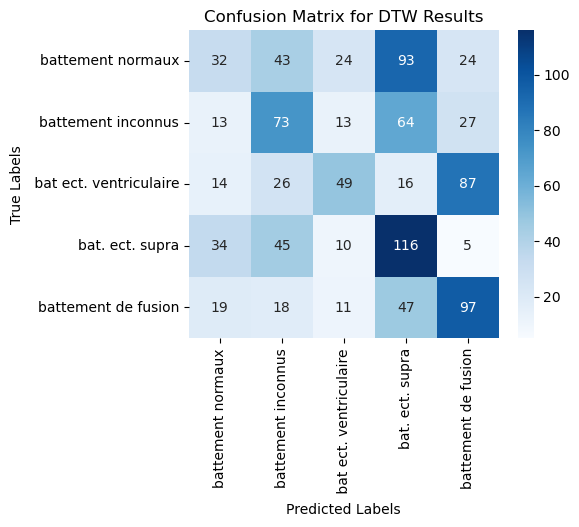

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(PartitionDTW[:, 0], PartitionDTW[:, 1])

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for DTW Results')
plt.show()

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

### Grid search - Random Forest

In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def grid_search_rf(data_features, labels, scaling=True):
    
    if scaling:
        scalerR = RobustScaler()
        data_features = scaler.fit_transform(data_features)
       
    # Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Initialisation du modèle
    rf_clf = RandomForestClassifier(random_state=42)

    # GridSearchCV avec validation croisée
    grid_search = GridSearchCV(
        rf_clf,
        param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    # Exécution de la recherche
    grid_search.fit(data_features, labels)


    print(f"✅ Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"🎯 Meilleur score : {grid_search.best_score_}")

    return grid_search.best_estimator_, grid_search.best_score_


In [282]:
data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models = {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_T"], acc = grid_search_rf(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models[name+"_F"], acc = grid_search_rf(data, LabelF_train, False)



🔍 Entraînement sur all features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.9235022398778105

🔍 Entraînement sur Temp features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.891501548550556

🔍 Entraînement sur Stat features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Meilleur score : 0.8757506093164972

🔍 Entraînement sur Spec features...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
✅ Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_sampl

### Random Forest

In [287]:
# méthode de classification supervisé
# Random Forest
# Initialiser et entraîner le modèle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def rf_model(best_model, X_test, y_test, scaling=True):

    if scaling:
        scalerR = RobustScaler()
        X_test = scaler.fit_transform(X_test)

    # Prédictions sur les données de test
    y_pred = best_model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f" Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy




 All features : 
 Accuracy du modèle RandomForest : 0.918
 Accuracy du modèle RandomForest : 0.924

 Temporel features : 
 Accuracy du modèle RandomForest : 0.888
 Accuracy du modèle RandomForest : 0.902

 Statistic features : 
 Accuracy du modèle RandomForest : 0.881
 Accuracy du modèle RandomForest : 0.888

 Spectral features : 
 Accuracy du modèle RandomForest : 0.914
 Accuracy du modèle RandomForest : 0.917

 ECG features : 
 Accuracy du modèle RandomForest : 0.807
 Accuracy du modèle RandomForest : 0.977


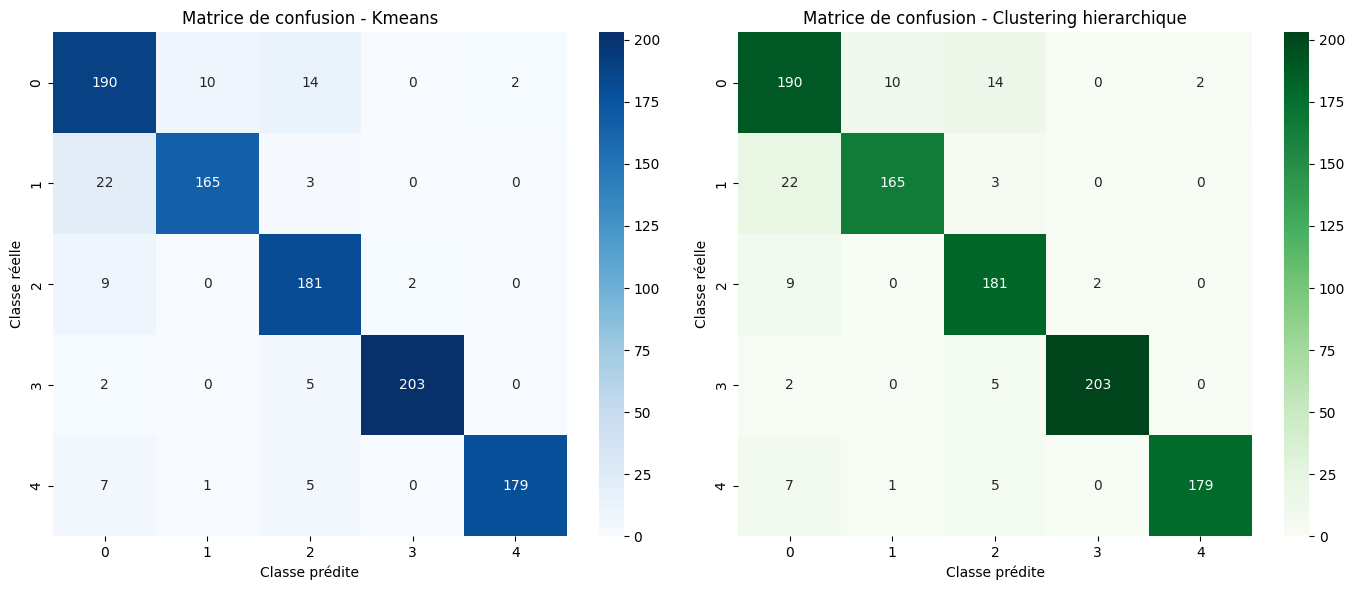

In [288]:
# Modèles avec toutes les données différentes

# Les modèles sont enregistré dans best_model

# Quand c'est False on a pas de scaling

# All features
print("\n All features : ")
y_pred_rf_all_T, accuracy_rf_all_T = rf_model(best_models["all_T"], DataFeatureTest, LabelF_test)
y_pred_rf_all_F, accuracy_rf_all_T = rf_model(best_models["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
print("\n Temporel features : ")
y_pred_rf_Temp_T, accuracy_rf_Temp_T = rf_model(best_models["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_rf_Temp_F, accuracy_rf_Temp_T = rf_model(best_models["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
print("\n Statistic features : ")
y_pred_rf_Stat_T, accuracy_rf_Stat_T = rf_model(best_models["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_rf_Stat_F, accuracy_rf_Stat_T = rf_model(best_models["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
print("\n Spectral features : ")
y_pred_rf_Spec_T, accuracy_rf_Spec_T = rf_model(best_models["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_rf_Spec_F, accuracy_rf_Spec_T = rf_model(best_models["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
print("\n ECG features : ")
y_pred_rf_ECG_T, accuracy_rf_ECG_T = rf_model(best_models["ECG_T"], DataECGTest, LabelF_test)
y_pred_rf_ECG_F, accuracy_rf_ECG_T = rf_model(best_models["ECG_F"], DataECGTest, LabelF_test, False)



### Grid search KNN

In [296]:
# Grid search pour trouver les meilleurs paramètres pour notre KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def grid_search_knn(data_features, labels, scaling=True):
    
    if scaling:
        scalerR = RobustScaler()
        data_features = scaler.fit_transform(data_features)
        
    # Définition du modèle
    knn = KNeighborsClassifier()
    
    # Définition de la grille de recherche
    param_grid = {
        "n_neighbors": [1, 3, 5, 7, 10, 15, 20],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    }
    
    # Initialisation de GridSearchCV
    grid_search_knn = GridSearchCV(
        knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    
    # Exécution de GridSearchCV
    grid_search_knn.fit(data_features, labels)
    
    print("Meilleurs hyperparamètres :", grid_search_knn.best_params_)
    print("Meilleur score :", grid_search_knn.best_score_)
    
    return grid_search_knn.best_estimator_, grid_search_knn.best_score_
    


In [298]:
data_dict = {
    "all": DataFeatureApp,
    "Temp": DataFeatureAppTemp,
    "Stat": DataFeatureAppStat,
    "Spec": DataFeatureAppSpec,
    "ECG": DataECGApp
}

best_models_knn = {}

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_T"], acc = grid_search_knn(data, LabelF_train)

for name, data in data_dict.items():
    print(f"\n🔍 Entraînement sur {name} features...")
    best_models_knn[name+"_F"], acc = grid_search_knn(data, LabelF_train, False)


🔍 Entraînement sur all features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.9245000000000001

🔍 Entraînement sur Temp features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.8949999999999999

🔍 Entraînement sur Stat features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Meilleur score : 0.866

🔍 Entraînement sur Spec features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Meilleur score : 0.9189999999999999

🔍 Entraînement sur ECG features...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Meilleu

### KNN

In [302]:
# k-Nearest Neighbors
# méthode de classification supervisé

from sklearn.neighbors import KNeighborsClassifier
def knn_model(model,  X_test, y_test, scaling=True):
    if scaling:
        scalerR = RobustScaler()
        X_test = scaler.fit_transform(X_test)
        
    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"🏆 Accuracy du modèle RandomForest : {accuracy}")
    return y_pred, accuracy
    
    

In [303]:
# Les modèles sont enregistrés dans best_model

# All features
y_pred_knn_all_T, accuracy_knn_all_T = knn_model(best_models_knn["all_T"], DataFeatureTest, LabelF_test)
y_pred_knn_all_F, accuracy_knn_all_T = knn_model(best_models_knn["all_F"], DataFeatureTest, LabelF_test, False)

# Temporel features
y_pred_knn_Temp_T, accuracy_knn_Temp_T = knn_model(best_models_knn["Temp_T"], DataFeatureTestTemp, LabelF_test)
y_pred_knn_Temp_F, accuracy_knn_Temp_T = knn_model(best_models_knn["Temp_F"], DataFeatureTestTemp, LabelF_test, False)

# Statistic features
y_pred_knn_Stat_T, accuracy_knn_Stat_T = knn_model(best_models_knn["Stat_T"], DataFeatureTestStat, LabelF_test)
y_pred_knn_Stat_F, accuracy_knn_Stat_T = knn_model(best_models_knn["Stat_F"], DataFeatureTestStat, LabelF_test, False)

# Spectral features
y_pred_knn_Spec_T, accuracy_knn_Spec_T = knn_model(best_models_knn["Spec_T"], DataFeatureTestSpec, LabelF_test)
y_pred_knn_Spec_F, accuracy_knn_Spec_T = knn_model(best_models_knn["Spec_F"], DataFeatureTestSpec, LabelF_test, False)

# ECG sans features
y_pred_knn_ECG_T, accuracy_knn_ECG_T = knn_model(best_models_knn["ECG_T"], DataECGTest, LabelF_test)
y_pred_knn_ECG_F, accuracy_knn_ECG_T = knn_model(best_models_knn["ECG_F"], DataECGTest, LabelF_test, False)


🏆 Accuracy du modèle RandomForest : 0.916
🏆 Accuracy du modèle RandomForest : 0.858
🏆 Accuracy du modèle RandomForest : 0.885
🏆 Accuracy du modèle RandomForest : 0.802
🏆 Accuracy du modèle RandomForest : 0.861
🏆 Accuracy du modèle RandomForest : 0.849
🏆 Accuracy du modèle RandomForest : 0.915
🏆 Accuracy du modèle RandomForest : 0.775
🏆 Accuracy du modèle RandomForest : 0.849
🏆 Accuracy du modèle RandomForest : 0.987


In [304]:
# Visualisation des matrices de confusion pour Kmeans de décision et DBScan
import seaborn as sns
import matplotlib.pyplot as plt

def display_matrix_s(m1,m2):
    plt.figure(figsize=(14, 6))
    
    # Matrice arbre de decision
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title("Matrice de confusion - Random Forest")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title("Matrice de confusion - KNN")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()

In [308]:
from sklearn.metrics import confusion_matrix


# Random Forest
conf_matrix_rf_all_T = confusion_matrix(LabelF_test, y_pred_rf_all_T)
conf_matrix_rf_all_F = confusion_matrix(LabelF_test, y_pred_rf_all_F)

conf_matrix_rf_Temp_T = confusion_matrix(LabelF_test, y_pred_rf_Temp_T)
conf_matrix_rf_Temp_F = confusion_matrix(LabelF_test, y_pred_rf_Temp_F)

conf_matrix_rf_Spec_T = confusion_matrix(LabelF_test, y_pred_rf_Spec_T)
conf_matrix_rf_Spec_F = confusion_matrix(LabelF_test, y_pred_rf_Spec_F)

conf_matrix_rf_Stat_T = confusion_matrix(LabelF_test, y_pred_rf_Stat_T)
conf_matrix_rf_Stat_F = confusion_matrix(LabelF_test, y_pred_rf_Stat_F)

conf_matrix_rf_ECG_T = confusion_matrix(LabelF_test, y_pred_rf_ECG_T)
conf_matrix_rf_ECG_F = confusion_matrix(LabelF_test, y_pred_rf_ECG_F)



# KNN

conf_matrix_knn_all_T = confusion_matrix(LabelF_test, y_pred_knn_all_T)
conf_matrix_knn_all_F = confusion_matrix(LabelF_test, y_pred_knn_all_F)

conf_matrix_knn_Temp_T = confusion_matrix(LabelF_test, y_pred_knn_Temp_T)
conf_matrix_knn_Temp_F = confusion_matrix(LabelF_test, y_pred_knn_Temp_F)

conf_matrix_knn_Spec_T = confusion_matrix(LabelF_test, y_pred_knn_Spec_T)
conf_matrix_knn_Spec_F = confusion_matrix(LabelF_test, y_pred_knn_Spec_F)

conf_matrix_knn_Stat_T = confusion_matrix(LabelF_test, y_pred_knn_Stat_T)
conf_matrix_knn_Stat_F = confusion_matrix(LabelF_test, y_pred_knn_Stat_F)

conf_matrix_knn_ECG_T = confusion_matrix(LabelF_test, y_pred_knn_ECG_T)
conf_matrix_knn_ECG_F = confusion_matrix(LabelF_test, y_pred_knn_ECG_F)



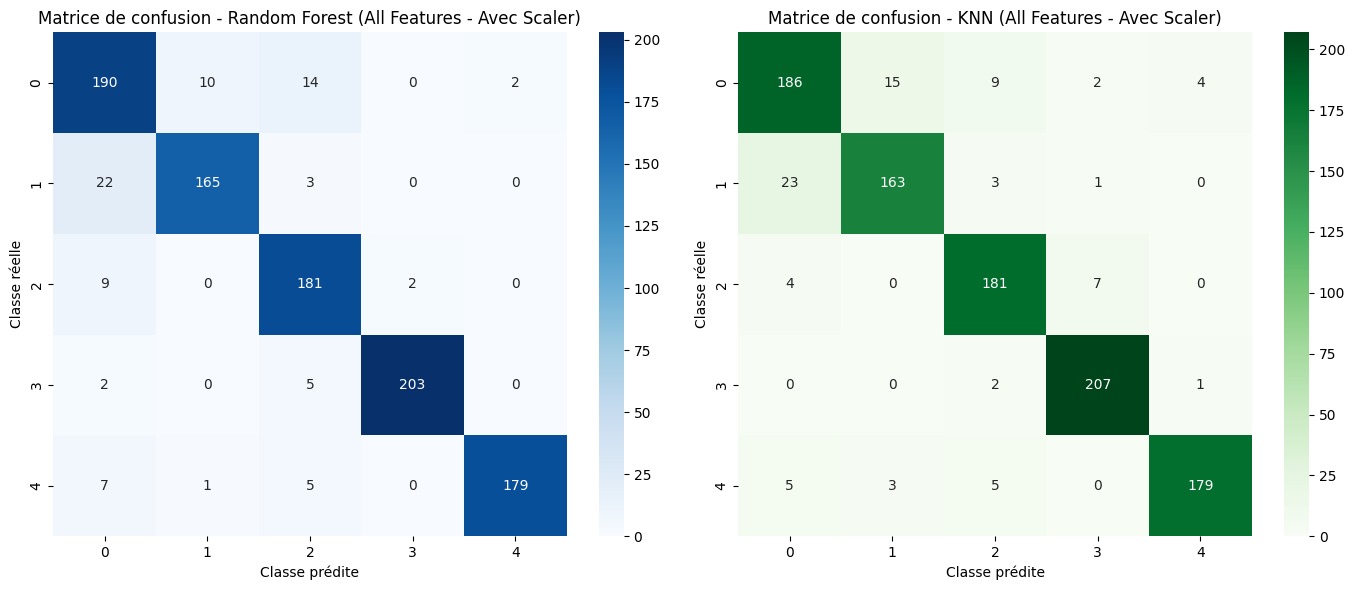

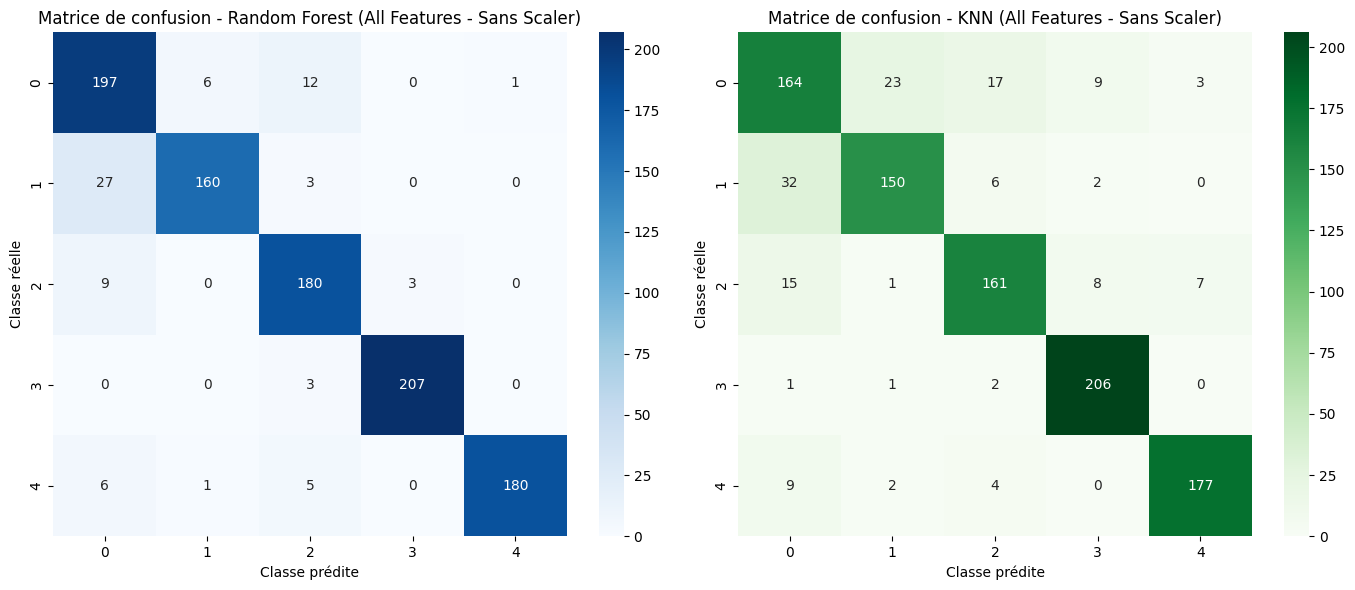

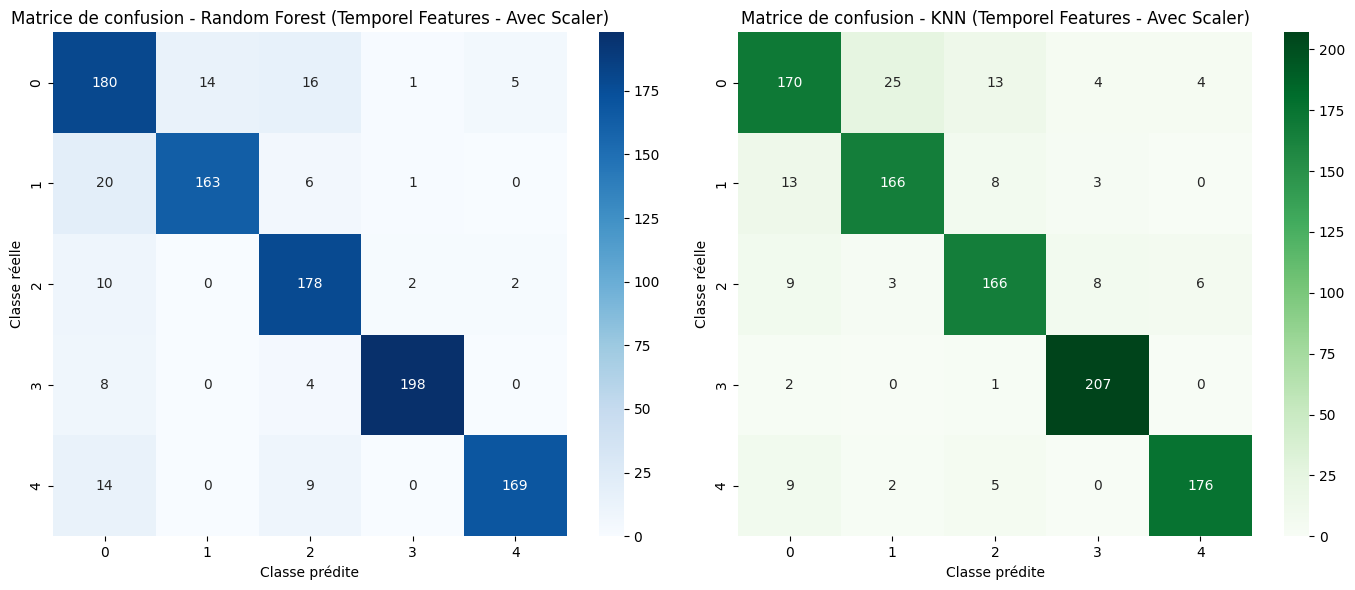

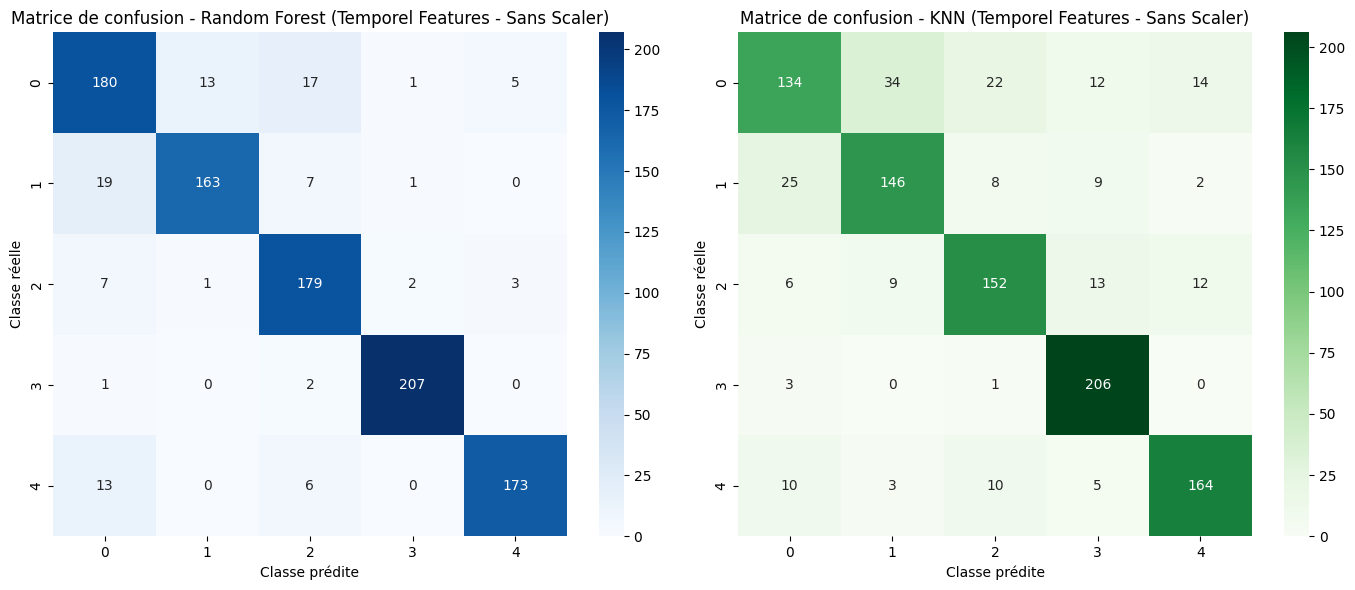

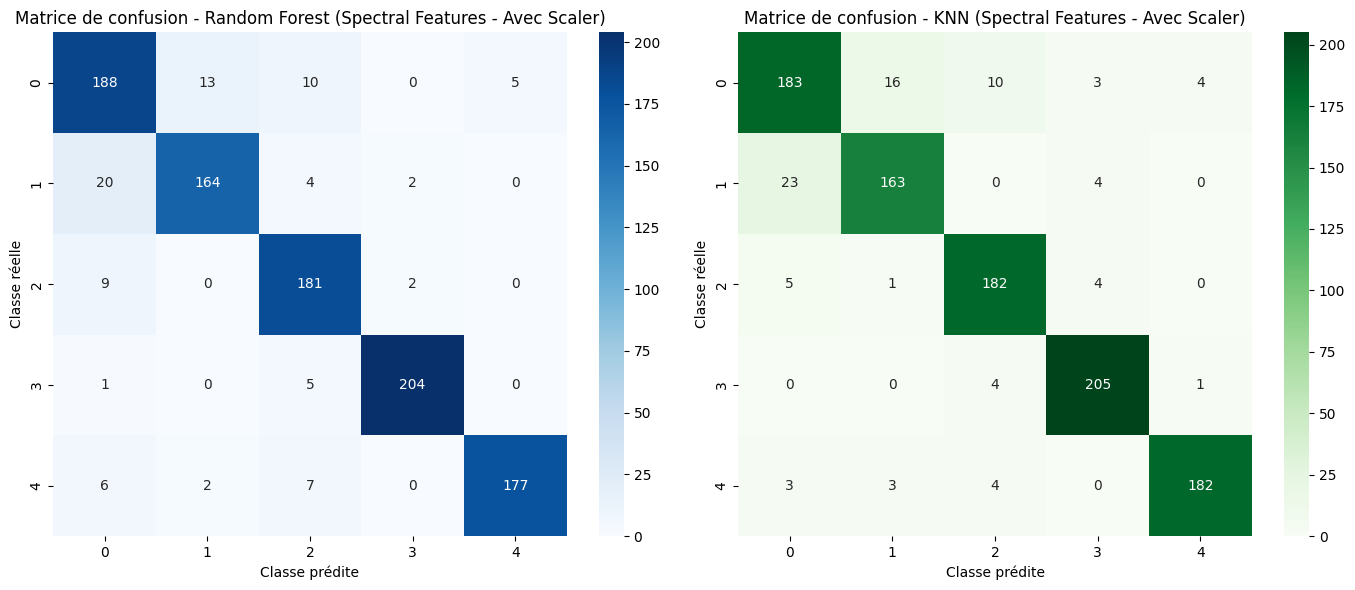

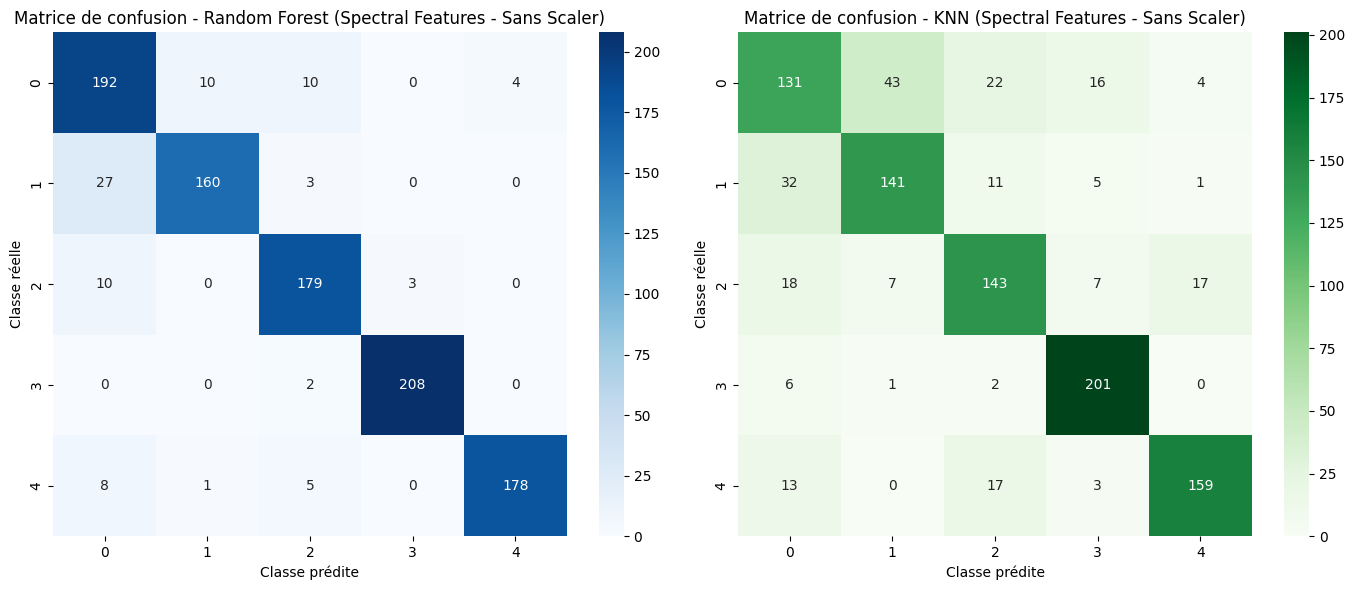

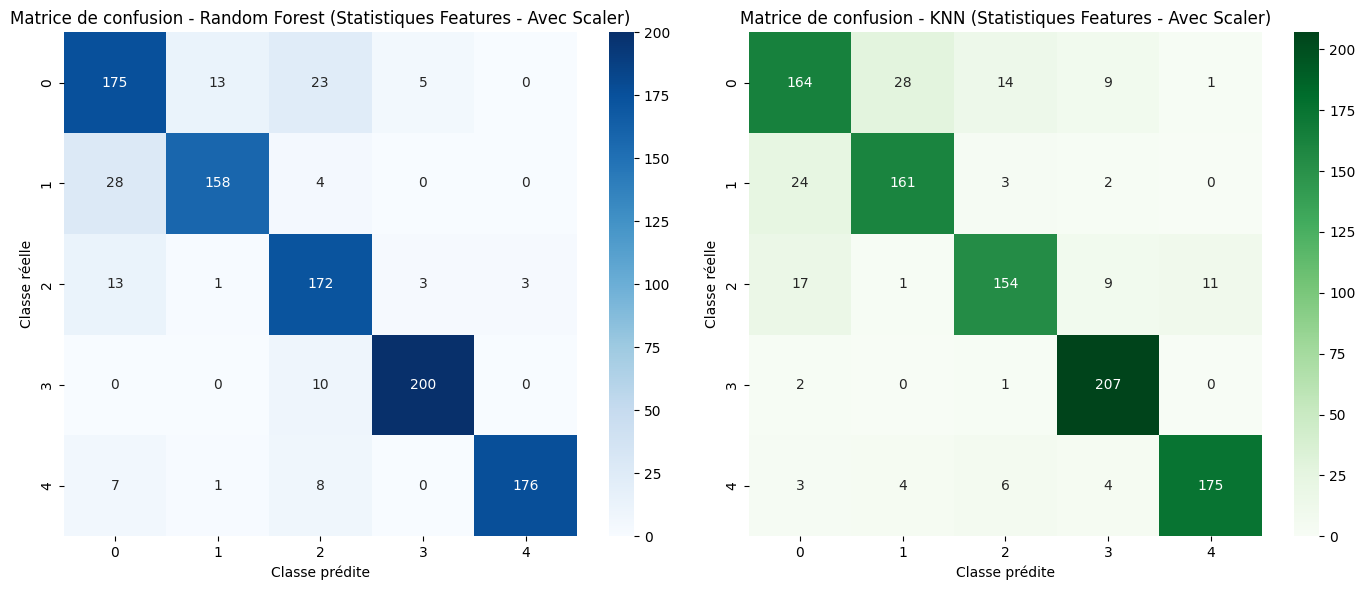

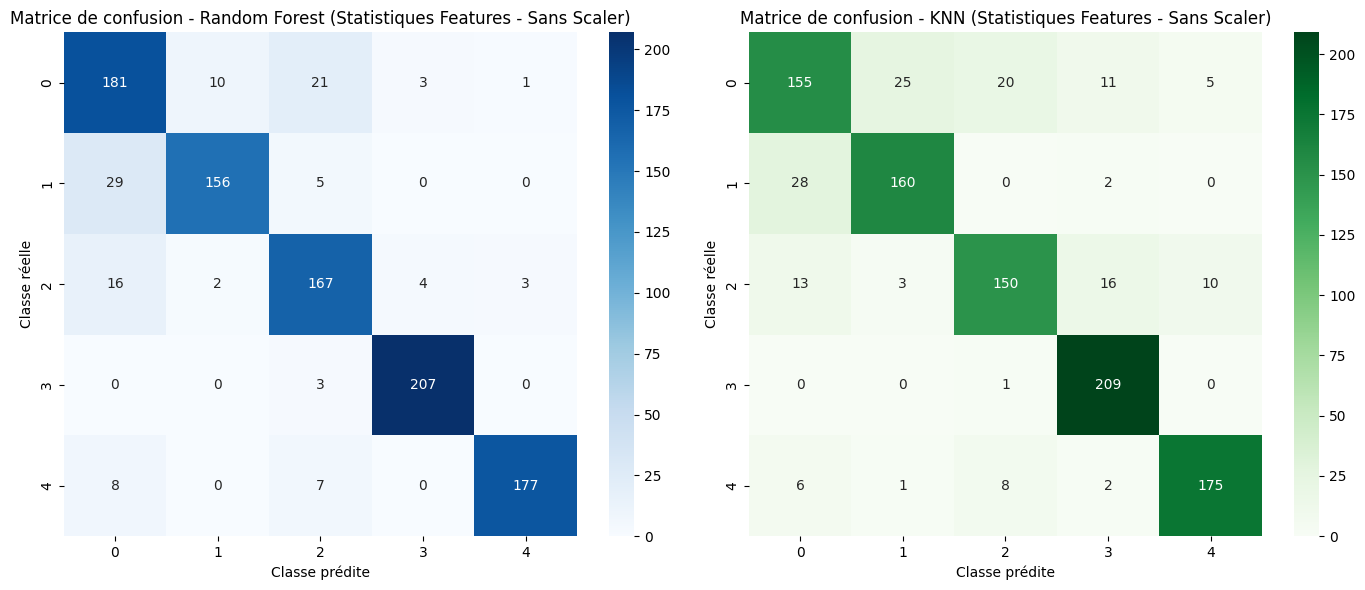

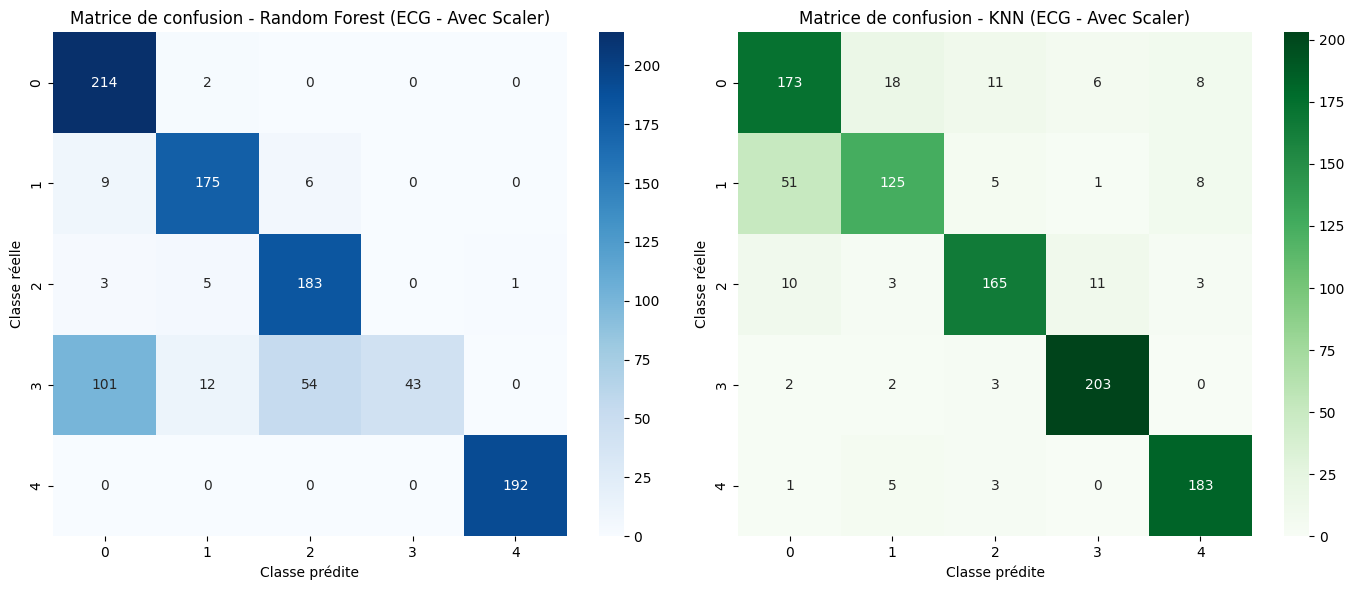

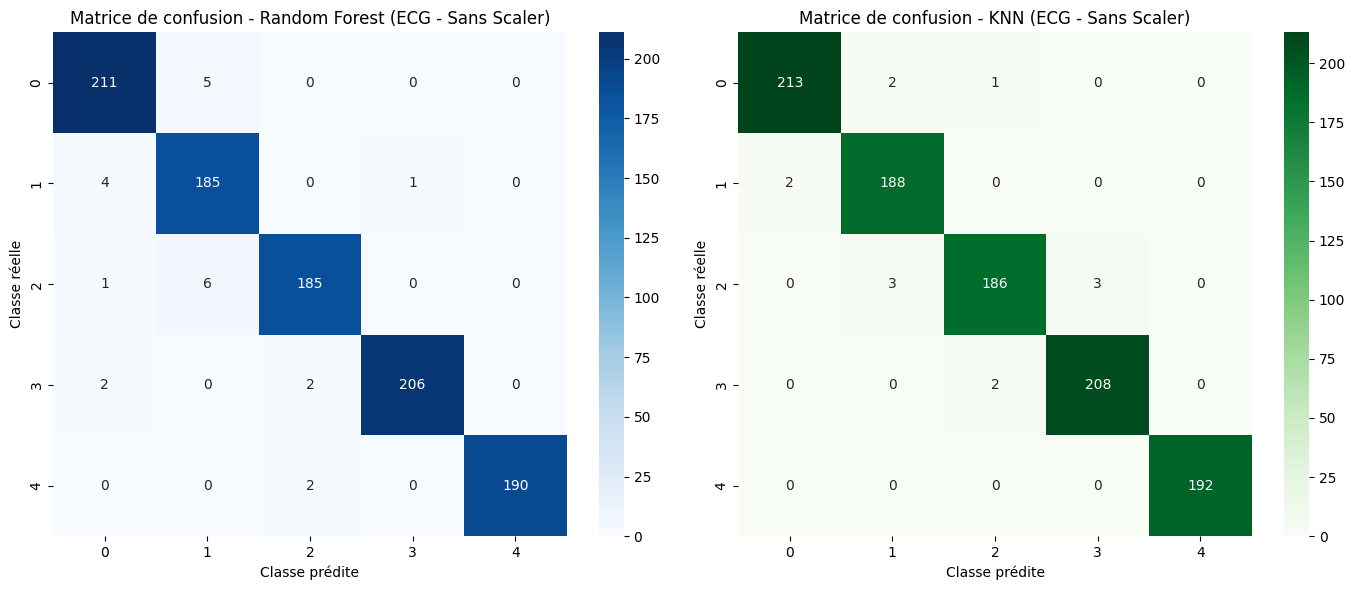

In [325]:
# Display matrice de confusion

def display_matrix_s(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Random Forest ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - KNN ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Appels de la fonction avec les bonnes matrices et titres
display_matrix_s(conf_matrix_rf_all_T, conf_matrix_knn_all_T, "All Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_all_F, conf_matrix_knn_all_F, "All Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Temp_T, conf_matrix_knn_Temp_T, "Temporel Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Temp_F, conf_matrix_knn_Temp_F, "Temporel Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Spec_T, conf_matrix_knn_Spec_T, "Spectral Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Spec_F, conf_matrix_knn_Spec_F, "Spectral Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_Stat_T, conf_matrix_knn_Stat_T, "Statistiques Features - Avec Scaler")
display_matrix_s(conf_matrix_rf_Stat_F, conf_matrix_knn_Stat_F, "Statistiques Features - Sans Scaler")

display_matrix_s(conf_matrix_rf_ECG_T, conf_matrix_knn_ECG_T, "ECG - Avec Scaler")
display_matrix_s(conf_matrix_rf_ECG_F, conf_matrix_knn_ECG_F, "ECG - Sans Scaler")


## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.  
 <b>Kmeans</b> et <b>Clustering Hierarchique</b>

### Score matrice de confusion

In [117]:
def conf_matrix_score(LabelF_train,y_pred):
    """
    Calcule le score d'une matrice de confusion.
    Le score est défini comme la somme des bonnes classifications par ligne divisées par le total de la ligne.
    fonction de score assez basique mais utile pour le réglage des hyper paramètres à partir
    des matrices de confusion
    """
    LabelF_train1 = LabelF_train.astype(int)

    # Conversion des clusters en labels réels
    y_pred_labels_temp = correspondance(y_pred, LabelF_train1)
    
    conf_matrix = confusion_matrix(LabelF_train, y_pred_labels_temp)
    
    score = 0
    for i in range(conf_matrix.shape[0]):
        total_in_row = np.sum(conf_matrix[i, :])
        if total_in_row > 0:
            score += conf_matrix[i, i] / total_in_row
    
    return (score / conf_matrix.shape[0])

### Kmeans recherche des meilleurs hyperparamètres

In [311]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def hyper_search_kmeans(data_features):
    # Normalisation Min-Max (valeurs entre 0 et 1)
    scalerM = MinMaxScaler()
    DataFeatureApp_scaledM = scaler.fit_transform(data_features)
    
    # Normalisation robuste (élimine l'effet des outliers)
    scalerR = RobustScaler()
    DataFeatureApp_scaledR = scaler.fit_transform(data_features)
    
    # Normalisation Standard
    scalerS = StandardScaler()
    DataFeatureApp_scaledS = scaler.fit_transform(data_features) 
    
    # Hyperparamètres
    param_grid = {
        "init": ["k-means++", "random"],
        "n_init": [10, 20, 30],
        "max_iter": [300, 500, 1000],
        "algorithm": ["lloyd", "elkan"],
        "tol": [1e-3, 1e-4, 1e-5],
        "data": {
           "RobustScaler": DataFeatureApp_scaledR,
            "StandardScaler" : DataFeatureApp_scaledS, 
            "MinMaxScaler" : DataFeatureApp_scaledM,
            "dataWithoutScale":data_features
        }
        
    }
    
    # Initialisation des meilleures valeurs
    best_confmatrix = 0
    best_params = {}
    
    # Teste des hyperparamètres
    for init in param_grid["init"]:
        for n_init in param_grid["n_init"]:
            for max_iter in param_grid["max_iter"]:
                for algorithm in param_grid["algorithm"]:
                    for tol in param_grid["tol"]: 
                        for scaler_name, data in param_grid["data"].items():
                            
                            # Création et entraînement du modèle K-Means
                            kmeans = KMeans(
                                n_clusters=5, init=init, n_init=n_init, 
                                max_iter=max_iter, algorithm=algorithm, 
                                tol=tol, random_state=42
                            )
    
                            
                            y_pred_km = kmeans.fit_predict(data)
                                
    
                            score_matrix = conf_matrix_score(LabelF_train, y_pred_km )
    
                            # Mise à jour paramètres
                            if score_matrix > best_confmatrix:
                                best_confmatrix = score_matrix
                                best_params = {
                                    "init": init,
                                    "n_init": n_init,
                                    "max_iter": max_iter,
                                    "algorithm": algorithm,
                                    "tol": tol,
                                    "data":scaler_name
                                }
    
    # Affichage best paramètres
    print(f"\n Meilleurs paramètres trouvés : {best_params} \n et meilleur score : {best_confmatrix}")


In [312]:
# Obtenir les meilleurs hyperparametres pour chaque type de données
dataList = [DataFeatureApp, DataFeatureAppTemp, DataFeatureAppStat, DataFeatureAppSpec, DataECGApp]

for d in dataList:
    hyper_search_kmeans(d)


 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 1e-05, 'data': 'RobustScaler'} 
 et meilleur score : 0.5523052952271318

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5156084125591583

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5357413950155314

 Meilleurs paramètres trouvés : {'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'RobustScaler'} 
 et meilleur score : 0.5486559162245339

 Meilleurs paramètres trouvés : {'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, 'data': 'dataWithoutScale'} 
 et meilleur score : 0.6320851852041315


### Kmeans

In [121]:
# méthode non supervisé
# kmeans

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def kmeans_model(data_features, params,scaling= True):
    if scaling:
        # Normalisation robuste (élimine l'effet des outliers)
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    kmeans = KMeans(**params)
    kmeans.fit(data_features)
    
    # Prédictions des clusters
    y_pred_km = kmeans.predict(data_features)
    
    LabelF_test1 = LabelF_test.astype(int)
    
    # Conversion des clusters en labels réels
    y_pred_labels_km = correspondance(y_pred_km, LabelF_test1)
    
    # Calcul de l'accuracy
    accuracy_km = accuracy_score(LabelF_test, y_pred_labels_km)
    
    # Calcul matrix score
    score_matrix_km = conf_matrix_score(LabelF_test, y_pred_km)
    
    #print(f"accuracy score de kmean : {accuracy_km}")
    return y_pred_km, accuracy_km, y_pred_labels_km, score_matrix_km

In [313]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 1e-05, "random_state": 42},
    "Temp":{"n_clusters": 5, 'init': 'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Stat":{"n_clusters": 5, 'init': 'random', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "Spec":{"n_clusters": 5,'init':'random', 'n_init': 10, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42},
    "ECG": {"n_clusters": 5, 'init': 'k-means++', 'n_init': 30, 'max_iter': 300, 'algorithm': 'lloyd', 'tol': 0.001, "random_state": 42}
}

# All features
y_pred_km_all_T, accuracy_km_all_T, y_pred_labels_km_all_T, score_matrix_km_all_T = kmeans_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_km_all_T} ; {score_matrix_km_all_T}")
y_pred_km_all_F, accuracy_km_all_F, y_pred_labels_km_all_F, score_matrix_km_all_F = kmeans_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_km_all_F } ; {score_matrix_km_all_F}")


# Temporel features
y_pred_km_Temp_T, accuracy_km_Temp_T, y_pred_labels_km_Temp_T, score_matrix_km_Temp_T = kmeans_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_km_Temp_T} ; {score_matrix_km_Temp_T}")
y_pred_km_Temp_F, accuracy_km_Temp_F, y_pred_labels_km_Temp_F, score_matrix_km_Temp_F = kmeans_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_km_Temp_F } ; {score_matrix_km_Temp_F}")

# Statistiques features
y_pred_km_Stat_T, accuracy_km_Stat_T, y_pred_labels_km_Stat_T, score_matrix_km_Stat_T = kmeans_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_km_Stat_T} ; {score_matrix_km_Stat_T}")
y_pred_km_Stat_F, accuracy_km_Stat_F, y_pred_labels_km_Stat_F, score_matrix_km_Stat_F = kmeans_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_km_Stat_F } ; {score_matrix_km_Stat_F}")

# Spectral features
y_pred_km_Spec_T, accuracy_km_Spec_T, y_pred_labels_km_Spec_T, score_matrix_km_Spec_T = kmeans_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_km_Spec_T} ; {score_matrix_km_Spec_T}")
y_pred_km_Spec_F, accuracy_km_Spec_F, y_pred_labels_km_Spec_F, score_matrix_km_Spec_F = kmeans_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_km_Spec_F } ; {score_matrix_km_Spec_F}")

# ECG sans features
y_pred_km_ECG_T, accuracy_km_ECG_T, y_pred_labels_km_ECG_T, score_matrix_km_ECG_T = kmeans_model(DataECGTest, model_grid["ECG"])
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_km_ECG_T} ; {score_matrix_km_ECG_T}")
y_pred_km_ECG_F, accuracy_km_ECG_F, y_pred_labels_km_ECG_F, score_matrix_km_ECG_F = kmeans_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_km_ECG_F } ; {score_matrix_km_ECG_F}")



Accuracy et matrix score de all features avec robust scaler : 0.551 ; 0.5583380325814536
Accuracy et matrix score de all features sans robust scaler : 0.409 ; 0.4097098649401281
Accuracy et matrix score de Temp features avec robust scaler : 0.464 ; 0.4670097117794486
Accuracy et matrix score de Temp features sans robust scaler : 0.464 ; 0.46118368838763574
Accuracy et matrix score de Stat features avec robust scaler : 0.505 ; 0.510891290726817
Accuracy et matrix score de Stat features sans robust scaler : 0.439 ; 0.44881422305764407
Accuracy et matrix score de Spec features avec robust scaler : 0.569 ; 0.5775814536340852
Accuracy et matrix score de Spec features sans robust scaler : 0.409 ; 0.4097098649401281
Accuracy et matrix score de ECG features avec robust scaler : 0.42 ; 0.41946428571428573
Accuracy et matrix score de ECG features sans robust scaler : 0.628 ; 0.615448343079922


In [71]:
# Verifier que tous le monde a changer de classes correctement
def assert_label_change(oldL,newL):
    i0 = np.where(oldL == 0)[0]
    i1 = np.where(oldL == 1)[0]
    i2 = np.where(oldL == 2)[0]
    i3 = np.where(oldL == 3)[0]
    i4 = np.where(oldL == 4)[0]
    
    
    assert np.all(newL[i0] == newL[i0[0]])
    assert np.all(newL[i1] == newL[i1[0]])
    assert np.all(newL[i2] == newL[i2[0]])
    assert np.all(newL[i3] == newL[i3[0]])
    assert np.all(newL[i4] == newL[i4[0]])


### Clustering hierarchique recherche des meilleurs paramètres

In [314]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import RobustScaler
import numpy as np

def CH_search(data_features):
   
    # Normalisation robuste (élimine l'effet des outliers)
    scaler = RobustScaler()
    data_features = scaler.fit_transform(data_features)
    
    # Définition des hyperparamètres pour Agglomerative Clustering
    param_grid = [
        {"linkage": ["ward"], "metric": ["euclidean"]},  # Ward impose euclidean
        {"linkage": ["complete", "average", "single"], "metric": ["euclidean", "l1", "l2", "manhattan", "cosine"]}
    ]
    
    # Initialisation des meilleurs paramètres
    best_score = -1
    best_params = None
    
    # Test des hyperparamètres
    for params in ParameterGrid(param_grid):
        try:
            # Création du modèle 
            agglo = AgglomerativeClustering(n_clusters=5, linkage=params["linkage"], metric=params["metric"])
            
            # Prédictions des clusters
            y_pred_ch = agglo.fit_predict(data_features)
           
            score = conf_matrix_score(LabelF_train, y_pred_ch)  
    
            # Mise à jour du meilleur modèle
            if score > best_score:
                best_score = score
                best_params = params
        
        except ValueError as e:
            print(f"Ignoré : {params} --> Erreur : {e}")
    
    # Affichage des meilleurs paramètres
    print("\n Meilleurs paramètres trouvés :", best_params)
    print("f Meilleur score : {best_score} \n")


In [316]:
# Obtenir les meilleurs hyperparametres pour chaque type de données
dataList = {
           "All features": DataFeatureApp,
            "Temporel features" : DataFeatureAppTemp, 
            "Statistic features" : DataFeatureAppStat,
            "Spectral features":DataFeatureAppSpec,
            "ECG": DataECGApp
        }

for scaler_name, data in dataList.items():
    print(scaler_name)
    CH_search(data)

All features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

Temporel features

 Meilleurs paramètres trouvés : {'linkage': 'complete', 'metric': 'cosine'}
f Meilleur score : {best_score} 

Statistic features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

Spectral features

 Meilleurs paramètres trouvés : {'linkage': 'ward', 'metric': 'euclidean'}
f Meilleur score : {best_score} 

ECG

 Meilleurs paramètres trouvés : {'linkage': 'average', 'metric': 'cosine'}
f Meilleur score : {best_score} 



### Clustering Hierarchique

In [317]:
from sklearn.cluster import AgglomerativeClustering


def CH_model(data_features, params,scaling= True):
    if scaling:
        scaler = RobustScaler()
        data_features = scaler.fit_transform(data_features)
    
    # model
    agglo = AgglomerativeClustering(n_clusters=5, **params)  # Peut tester aussi 'complete', 'average'
    
    # classification
    y_pred_ch = agglo.fit_predict(data_features)
    
    # Convertir en Int
    LabelF_test1 = LabelF_test.astype(int)
        
    # Conversion des clusters en labels réels
    y_pred_labels_ch = correspondance(y_pred_ch, LabelF_test1)
    
    # Calcul matrix score
    score_matrix_ch = conf_matrix_score(LabelF_test, y_pred_ch)
    
    # Calcul de l'accuracy
    accuracy_ch = accuracy_score(LabelF_test, y_pred_labels_ch)
    
    #print(f"accuracy score de CH : {accuracy_ch}")
    return y_pred_ch, accuracy_ch, y_pred_labels_ch, score_matrix_ch


In [318]:
# Test des différentes caractéristiques

# hperparamètres définit après recherche pour chaque type de données
model_grid = {
    "all":{'linkage': 'ward', 'metric': 'euclidean'},
    "Temp":{'linkage': 'complete', 'metric': 'cosine'},
    "Stat":{'linkage': 'ward', 'metric': 'euclidean'},
    "Spec":{'linkage': 'ward', 'metric': 'euclidean'},
    "ECG":{'linkage': 'average', 'metric': 'cosine'}
}

# All features
y_pred_ch_all_T, accuracy_ch_all_T, y_pred_labels_ch_all_T, score_matrix_ch_all_T = CH_model(DataFeatureTest, model_grid["all"] )
print(f"Accuracy et matrix score de all features avec robust scaler : {accuracy_ch_all_T} ; {score_matrix_ch_all_T}")
y_pred_ch_all_F, accuracy_ch_all_F, y_pred_labels_ch_all_F, score_matrix_ch_all_F = CH_model(DataFeatureTest,model_grid["all"], False)
print(f"Accuracy et matrix score de all features sans robust scaler : {accuracy_ch_all_F } ; {score_matrix_ch_all_F}")

# Temporel features
y_pred_ch_Temp_T, accuracy_ch_Temp_T, y_pred_labels_ch_Temp_T, score_matrix_ch_Temp_T = CH_model(DataFeatureTestTemp, model_grid["Temp"] )
print(f"Accuracy et matrix score de Temp features avec robust scaler : {accuracy_ch_Temp_T} ; {score_matrix_ch_Temp_T}")
y_pred_ch_Temp_F, accuracy_ch_Temp_F, y_pred_labels_ch_Temp_F, score_matrix_ch_Temp_F = CH_model(DataFeatureTestTemp, model_grid["Temp"],False)
print(f"Accuracy et matrix score de Temp features sans robust scaler : {accuracy_ch_Temp_F } ; {score_matrix_ch_Temp_F}")

# Statistiques features
y_pred_ch_Stat_T, accuracy_ch_Stat_T, y_pred_labels_ch_Stat_T, score_matrix_ch_Stat_T = CH_model(DataFeatureTestStat,  model_grid["Stat"] )
print(f"Accuracy et matrix score de Stat features avec robust scaler : {accuracy_ch_Stat_T} ; {score_matrix_ch_Stat_T}")
y_pred_ch_Stat_F, accuracy_ch_Stat_F, y_pred_labels_ch_Stat_F, score_matrix_ch_Stat_F = CH_model(DataFeatureTestStat,model_grid["Stat"], False)
print(f"Accuracy et matrix score de Stat features sans robust scaler : {accuracy_ch_Stat_F } ; {score_matrix_ch_Stat_F}")

# Spectral features
y_pred_ch_Spec_T, accuracy_ch_Spec_T, y_pred_labels_ch_Spec_T, score_matrix_ch_Spec_T = CH_model(DataFeatureTestSpec,  model_grid["Spec"] )
print(f"Accuracy et matrix score de Spec features avec robust scaler : {accuracy_ch_Spec_T} ; {score_matrix_ch_Spec_T}")
y_pred_ch_Spec_F, accuracy_ch_Spec_F, y_pred_labels_ch_Spec_F, score_matrix_ch_Spec_F = CH_model(DataFeatureTestSpec,model_grid["Spec"], False)
print(f"Accuracy et matrix score de Spec features sans robust scaler : {accuracy_ch_Spec_F } ; {score_matrix_ch_Spec_F}")

# ECG sans features
y_pred_ch_ECG_T, accuracy_ch_ECG_T, y_pred_labels_ch_ECG_T, score_matrix_ch_ECG_T = CH_model(DataECGTest,  model_grid["ECG"] )
print(f"Accuracy et matrix score de ECG features avec robust scaler : {accuracy_ch_ECG_T} ; {score_matrix_ch_ECG_T}")
y_pred_ch_ECG_F, accuracy_ch_ECG_F, y_pred_labels_ch_ECG_F, score_matrix_ch_ECG_F = CH_model(DataECGTest, model_grid["ECG"], False)
print(f"Accuracy et matrix score de ECG features sans robust scaler : {accuracy_ch_ECG_F } ; {score_matrix_ch_ECG_F}")




Accuracy et matrix score de all features avec robust scaler : 0.559 ; 0.5660902255639098
Accuracy et matrix score de all features sans robust scaler : 0.388 ; 0.3893295739348371
Accuracy et matrix score de Temp features avec robust scaler : 0.547 ; 0.5458677944862156
Accuracy et matrix score de Temp features sans robust scaler : 0.352 ; 0.3501488095238095
Accuracy et matrix score de Stat features avec robust scaler : 0.516 ; 0.5232315162907268
Accuracy et matrix score de Stat features sans robust scaler : 0.442 ; 0.45171679197994996
Accuracy et matrix score de Spec features avec robust scaler : 0.478 ; 0.4996491228070175
Accuracy et matrix score de Spec features sans robust scaler : 0.389 ; 0.3804034391534391
Accuracy et matrix score de ECG features avec robust scaler : 0.391 ; 0.3876455026455027
Accuracy et matrix score de ECG features sans robust scaler : 0.315 ; 0.2979824561403509


### Matrice de confusion

In [319]:

# KMEANS
conf_matrix_km_all_T = confusion_matrix(LabelF_test, y_pred_labels_km_all_T)
conf_matrix_km_all_F = confusion_matrix(LabelF_test, y_pred_labels_km_all_F)

conf_matrix_km_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_T)
conf_matrix_km_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_km_Temp_F)

conf_matrix_km_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_T)
conf_matrix_km_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_km_Spec_F)

conf_matrix_km_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_T)
conf_matrix_km_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_km_Stat_F)

conf_matrix_km_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_T)
conf_matrix_km_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_km_ECG_F)


# Clustering hierarchique

conf_matrix_ch_all_T = confusion_matrix(LabelF_test, y_pred_labels_ch_all_T)
conf_matrix_ch_all_F = confusion_matrix(LabelF_test, y_pred_labels_ch_all_F)

conf_matrix_ch_Temp_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_T)
conf_matrix_ch_Temp_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Temp_F)

conf_matrix_ch_Spec_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_T)
conf_matrix_ch_Spec_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Spec_F)

conf_matrix_ch_Stat_T = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_T)
conf_matrix_ch_Stat_F = confusion_matrix(LabelF_test, y_pred_labels_ch_Stat_F)

conf_matrix_ch_ECG_T = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_T)
conf_matrix_ch_ECG_F = confusion_matrix(LabelF_test, y_pred_labels_ch_ECG_F)



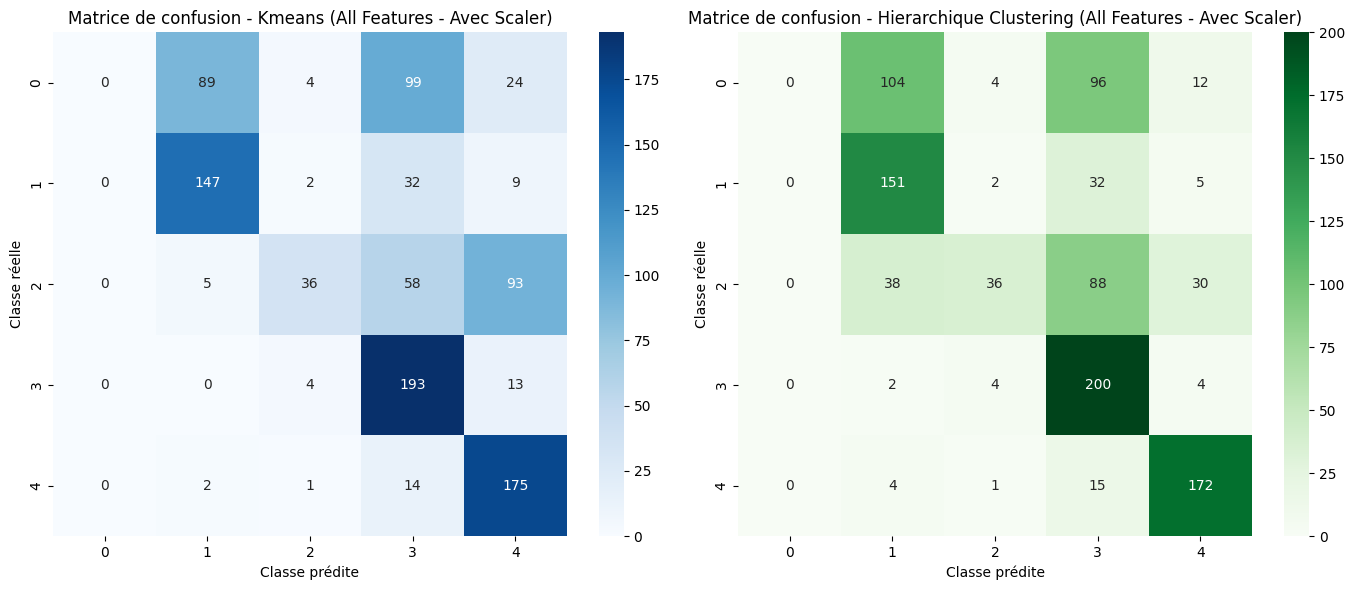

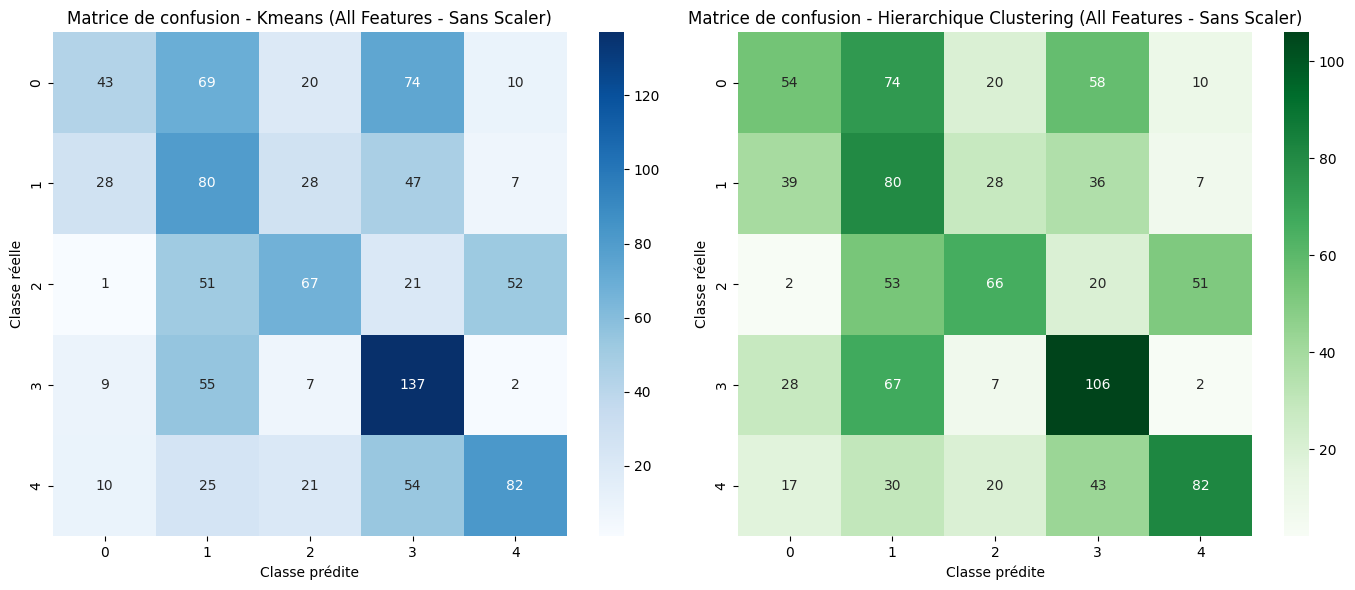

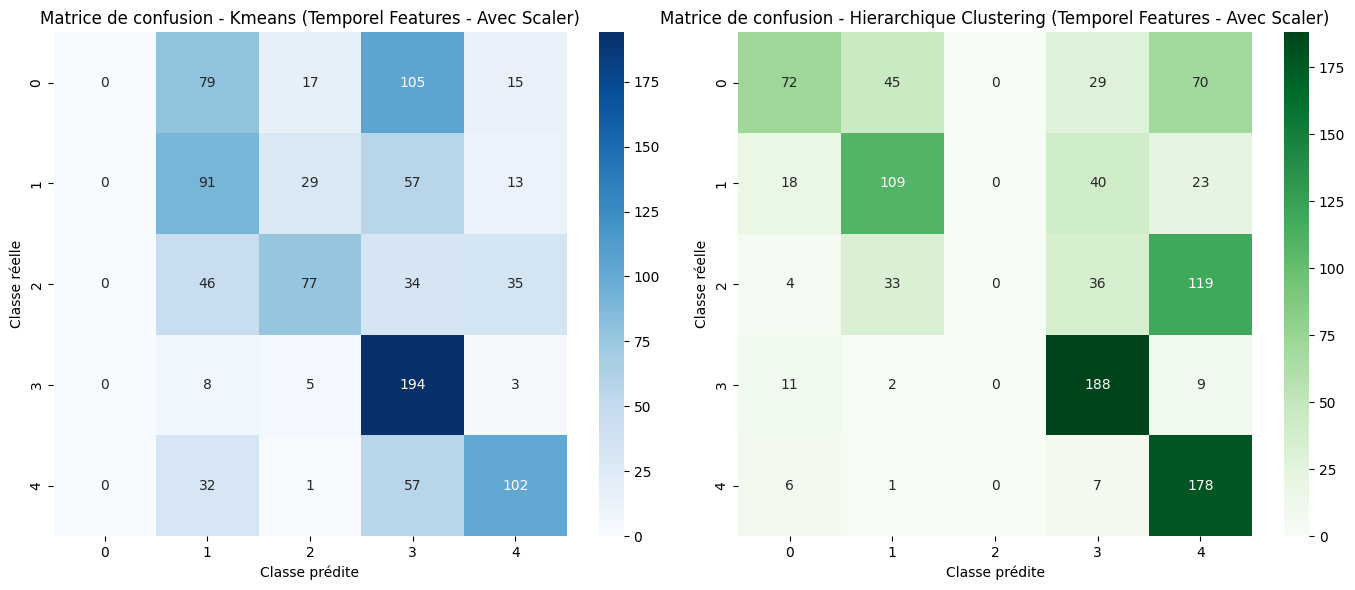

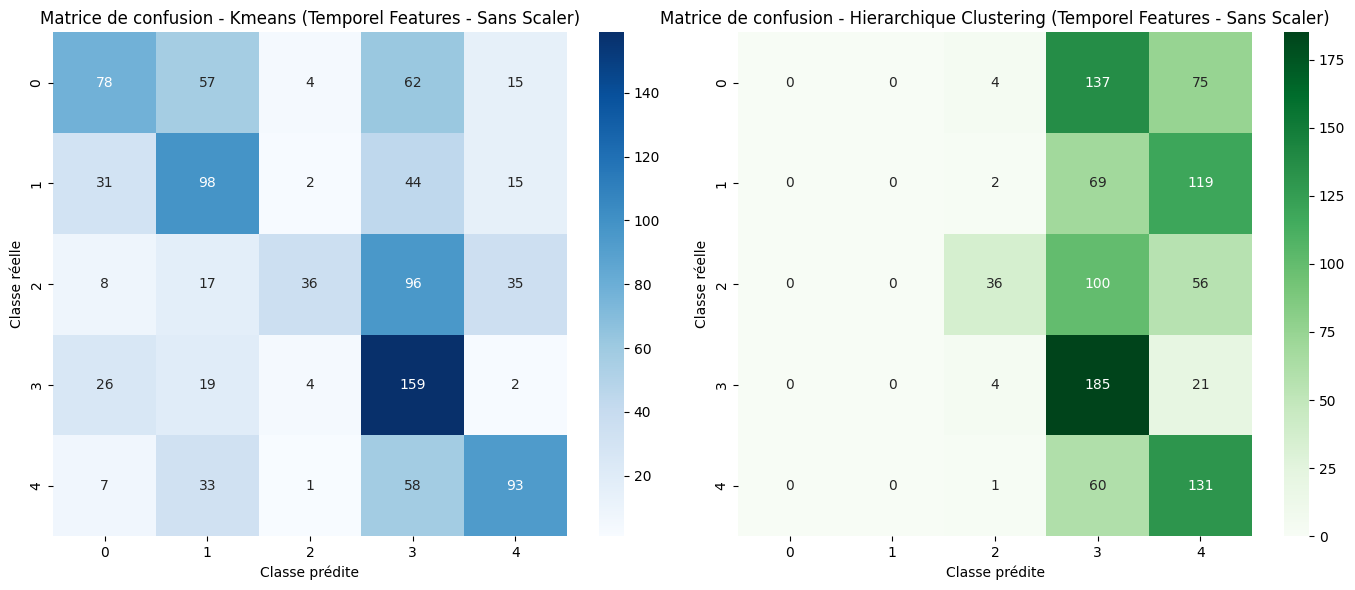

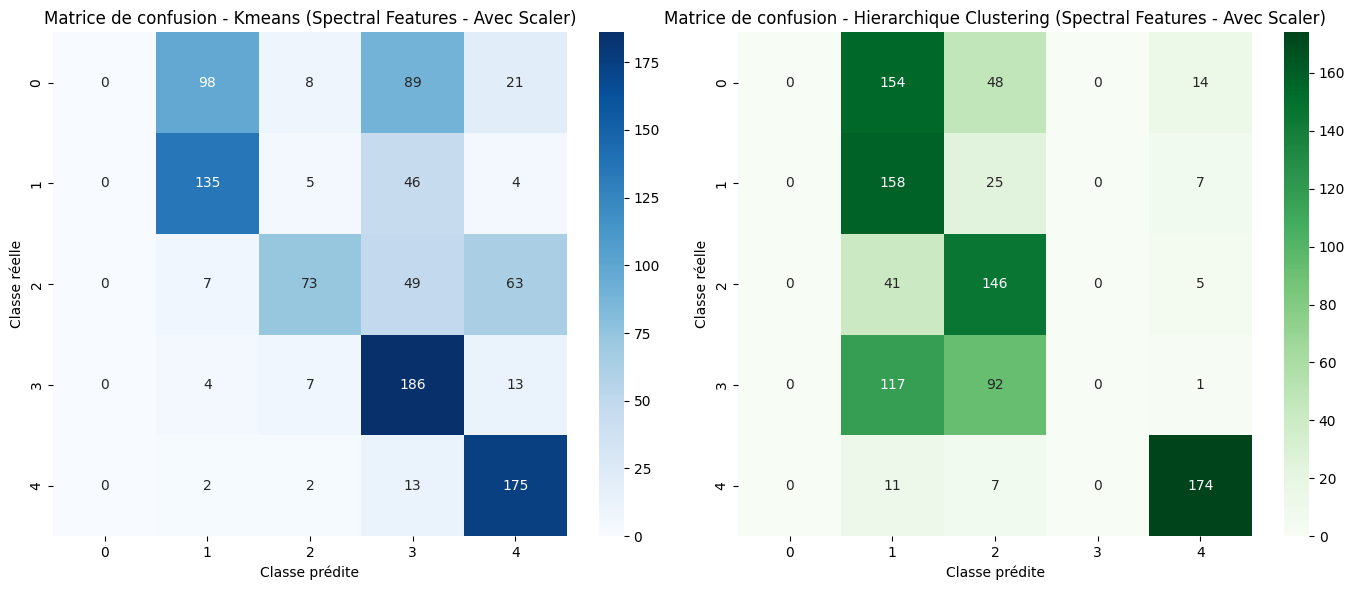

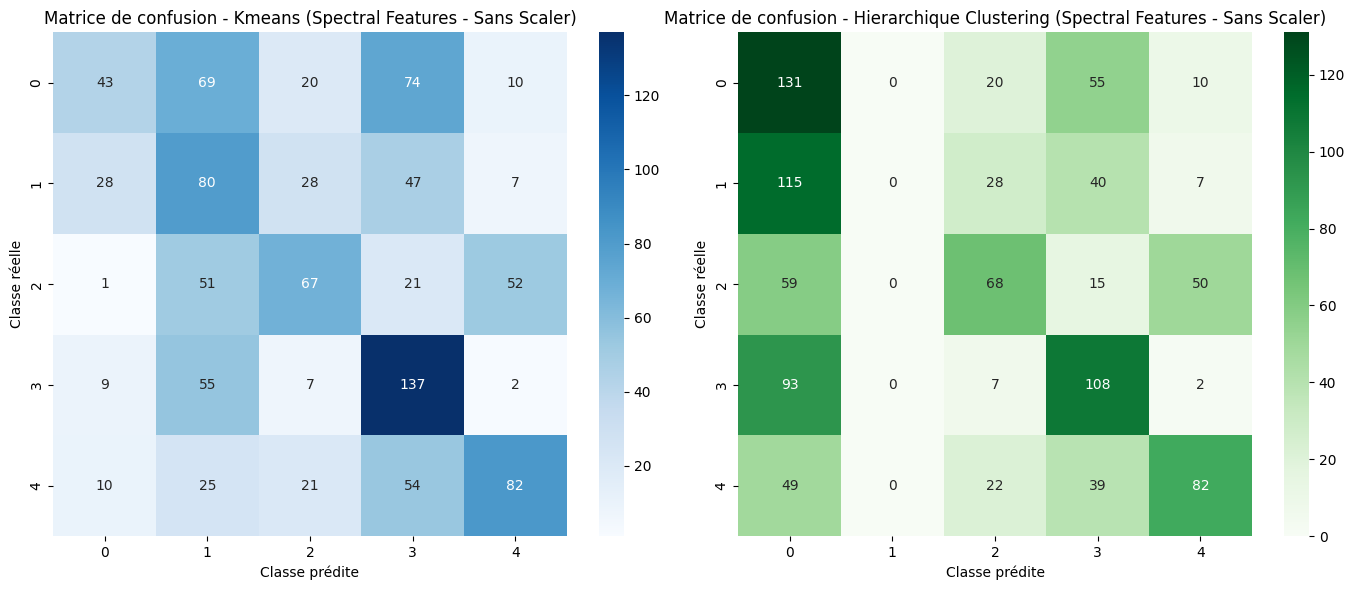

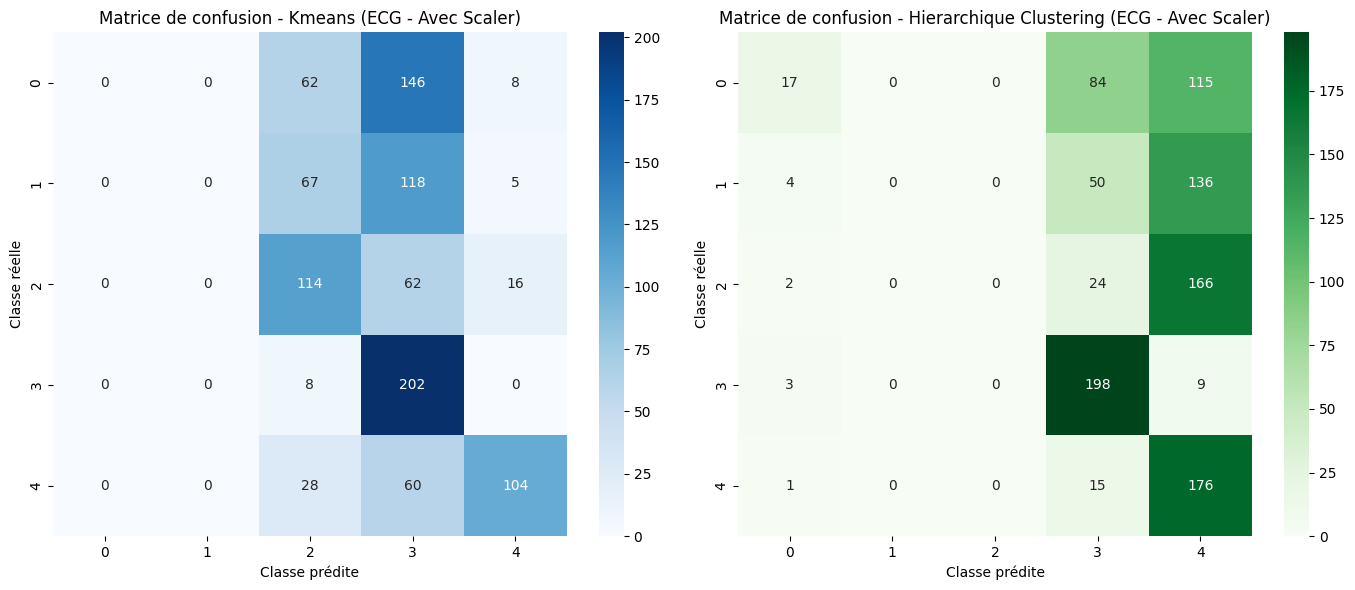

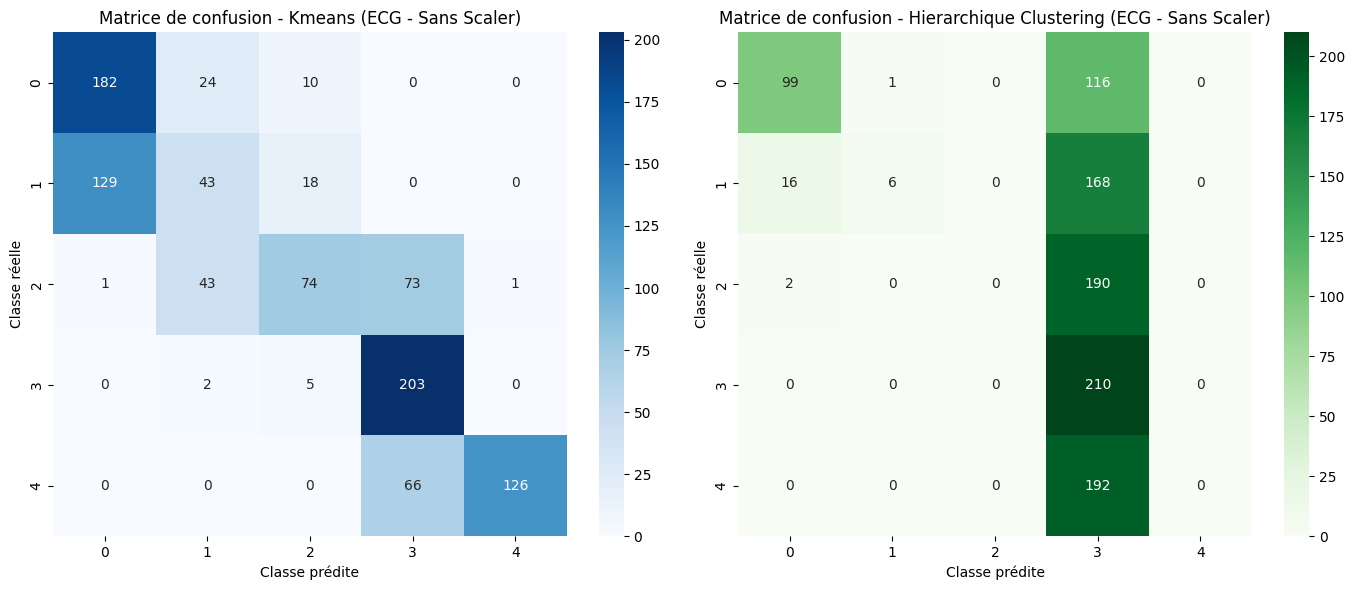

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display matrice de confusion

def display_matrix_ns(m1, m2, title):
    plt.figure(figsize=(14, 6))
    
    # Matrice Random Forest
    plt.subplot(1, 2, 1)
    sns.heatmap(m1, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion - Kmeans ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    # Matrice KNN
    plt.subplot(1, 2, 2)
    sns.heatmap(m2, annot=True, fmt="d", cmap="Greens")
    plt.title(f"Matrice de confusion - Hierarchique Clustering ({title})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    
    plt.tight_layout()
    plt.show()


# Affichage des matrices de confusion
display_matrix_ns(conf_matrix_km_all_T, conf_matrix_ch_all_T, 
                 "All Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_all_F, conf_matrix_ch_all_F, 
                 "All Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Temp_T, conf_matrix_ch_Temp_T, 
                 "Temporel Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Temp_F, conf_matrix_ch_Temp_F, 
                 "Temporel Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_Spec_T, conf_matrix_ch_Spec_T, 
                 "Spectral Features - Avec Scaler")

display_matrix_ns(conf_matrix_km_Spec_F, conf_matrix_ch_Spec_F, 
                "Spectral Features - Sans Scaler")

display_matrix_ns(conf_matrix_km_ECG_T, conf_matrix_ch_ECG_T, 
                "ECG - Avec Scaler")

display_matrix_ns(conf_matrix_km_ECG_F, conf_matrix_ch_ECG_F, 
                 "ECG - Sans Scaler")



# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [20]:
from sklearn.decomposition import PCA

Étape 1 : Préparation et Normalisation des données
python


In [21]:
from sklearn.preprocessing import StandardScaler

# Normalisation des données (toutes caractéristiques combinées)
scaler = StandardScaler()
DataFeature_scaled = scaler.fit_transform(DataFeature)

# Vérification des dimensions
print("Taille des données normalisées :", DataFeature_scaled.shape)


Taille des données normalisées : (5000, 156)


Étape 2 : Application de l'ACP sur toutes les caractéristiques


In [22]:
from sklearn.decomposition import PCA

# Application de l'ACP
pca = PCA(n_components=0.95)  # Conserver 95% de la variance
DataFeature_pca = pca.fit_transform(DataFeature_scaled)

# Vérification des dimensions après réduction
print("Nombre de dimensions après ACP :", DataFeature_pca.shape[1])


Nombre de dimensions après ACP : 36


In [23]:
from sklearn.model_selection import train_test_split

# Division des données
DataFeatureApp_pca, DataFeatureTest_pca, Label_train, Label_test = train_test_split(
    DataFeature_pca, Label, test_size=0.2, random_state=42
)

print("Taille des données après division :")
print("Ensemble d'apprentissage :", DataFeatureApp_pca.shape)
print("Ensemble de test :", DataFeatureTest_pca.shape)


Taille des données après division :
Ensemble d'apprentissage : (4000, 36)
Ensemble de test : (1000, 36)


Étape 4 : Classification supervisée

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Entraînement SVM
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(DataFeatureApp_pca, Label_train)

# Prédictions sur l'ensemble de test
svm_predictions = svm.predict(DataFeatureTest_pca)

# Matrice de confusion
svm_cm = confusion_matrix(Label_test, svm_predictions)
print("Matrice de confusion - SVM :")
print(svm_cm)


Matrice de confusion - SVM :
[[184  14  12   5   1]
 [ 43 140   4   3   0]
 [  6   0 177   8   1]
 [  2   1   9 198   0]
 [  6   1   7   1 177]]


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(DataFeatureApp_pca, Label_train)

# Prédictions sur l'ensemble de test
rf_predictions = rf.predict(DataFeatureTest_pca)

# Matrice de confusion
rf_cm = confusion_matrix(Label_test, rf_predictions)
print("Matrice de confusion - Random Forest :")
print(rf_cm)


Matrice de confusion - Random Forest :
[[187   9  12   2   6]
 [ 26 159   4   1   0]
 [  8   0 179   5   0]
 [  0   0   1 209   0]
 [  9   0   9   1 173]]


Étape 5 : Visualisation des matrices de confusion
python

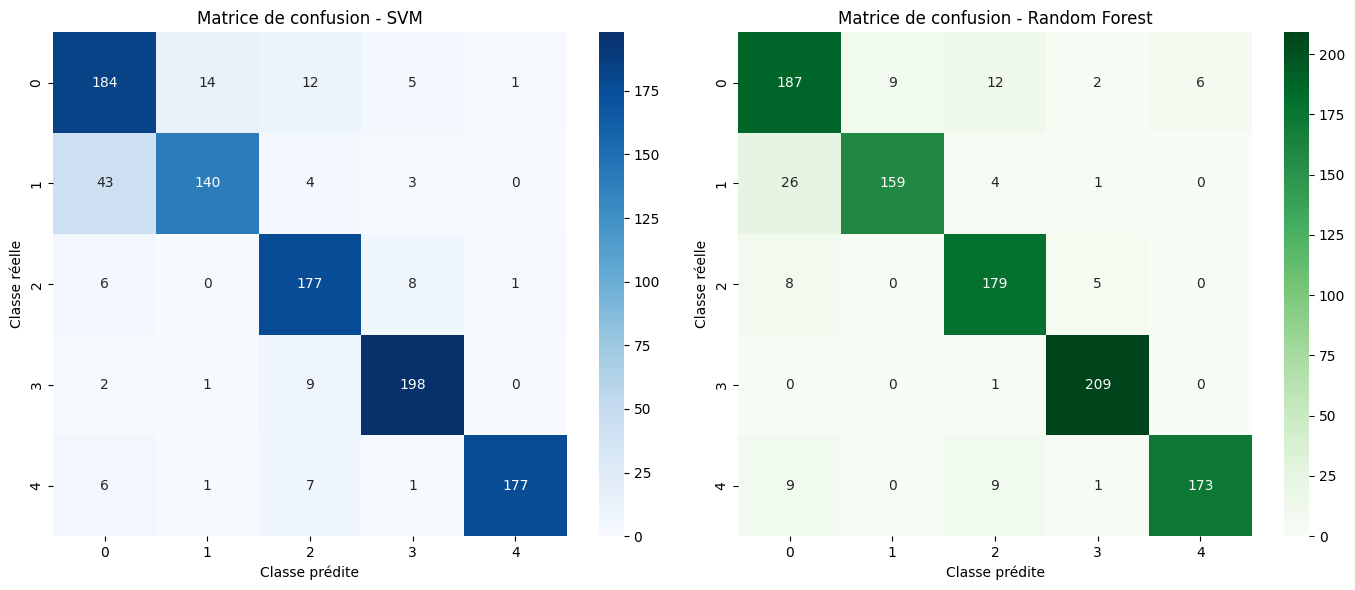

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Matrice SVM
plt.subplot(1, 2, 1)
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - SVM")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# Matrice Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import accuracy_score

# Score SVM
svm_accuracy = accuracy_score(Label_test, svm_predictions)
print("Accuracy - SVM :", svm_accuracy)

# Score Random Forest
rf_accuracy = accuracy_score(Label_test, rf_predictions)
print("Accuracy - Random Forest :", rf_accuracy)


Accuracy - SVM : 0.876
Accuracy - Random Forest : 0.907


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [29]:
from sklearn.decomposition import PCA



### Étape 1 : Réduction de dimension avec ACP (3 pourcentages différents)

Dans cette étape, nous appliquerons l'ACP aux données avec 95%, 85%, et 75% de variance expliquée, sans standardisation.

In [41]:
import numpy as np
from sklearn.decomposition import PCA

# Charger les données
all_features = np.vstack([DataFeatureApp, DataFeatureTest])
all_labels = np.concatenate([LabelF_train, LabelF_test])

# Réduction de dimension par ACP avec 3 niveaux de variance expliquée
variances = [0.95, 0.85, 0.75]
pca_results = {}

for var in variances:
    # Appliquer l'ACP
    pca = PCA(n_components=var)
    reduced_data = pca.fit_transform(all_features)
    pca_results[var] = reduced_data
    
    # Afficher les informations sur les composantes
    print(f"\n--- ACP avec {var*100}% de variance expliquée ---")
    print(f"Nombre de composantes : {pca.n_components_}")
    print(f"Variance expliquée cumulée : {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Dimensions réduites : {reduced_data.shape}")



--- ACP avec 95.0% de variance expliquée ---
Nombre de composantes : 1
Variance expliquée cumulée : 0.9912
Dimensions réduites : (5000, 1)

--- ACP avec 85.0% de variance expliquée ---
Nombre de composantes : 1
Variance expliquée cumulée : 0.9912
Dimensions réduites : (5000, 1)

--- ACP avec 75.0% de variance expliquée ---
Nombre de composantes : 1
Variance expliquée cumulée : 0.9912
Dimensions réduites : (5000, 1)


ACP ait réduit les dimensions à une seule composante indique que l'ensemble des données a une très forte redondance (variance expliquée très élevée par une seule composante principale)

pour résoudre le problème Réintroduire une standardisation 

In [43]:
from sklearn.preprocessing import StandardScaler
# Appliquer la standardisation
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

#### Étape 2 : Réduction de dimension avec ACP


Appliquez l’ACP pour capturer 95%, 85%, et 75% de la variance expliquée.


In [44]:
# Fonction pour appliquer l'ACP
def apply_pca(data, variance_thresholds):
    results = {}
    for threshold in variance_thresholds:
        # Appliquer l'ACP
        pca = PCA(n_components=threshold)
        reduced_data = pca.fit_transform(data)

        # Stocker les résultats
        results[threshold] = {
            "n_components": pca.n_components_,
            "explained_variance": np.sum(pca.explained_variance_ratio_),
            "reduced_data": reduced_data
        }

        # Afficher les informations
        print(f"--- ACP avec {threshold * 100:.1f}% de variance expliquée ---")
        print("Nombre de composantes :", pca.n_components_)
        print("Variance expliquée cumulée :", np.sum(pca.explained_variance_ratio_))
    return results

# Appliquer l'ACP avec différents seuils
variance_thresholds = [0.95, 0.85, 0.75]
pca_results = apply_pca(all_features_scaled, variance_thresholds)


--- ACP avec 95.0% de variance expliquée ---
Nombre de composantes : 36
Variance expliquée cumulée : 0.9517068297577358
--- ACP avec 85.0% de variance expliquée ---
Nombre de composantes : 15
Variance expliquée cumulée : 0.8513569665067052
--- ACP avec 75.0% de variance expliquée ---
Nombre de composantes : 8
Variance expliquée cumulée : 0.7674189130389135


#### Étape 3 : Appliquer K-Means et DBSCAN


In [48]:
# Fonction pour appliquer K-Means
def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    return labels

# Appliquer K-Means sur les données réduites
n_clusters = 5
for threshold in variance_thresholds:
    reduced_data = pca_results[threshold]["reduced_data"]
    predicted_labels_kmeans = apply_kmeans(reduced_data, n_clusters)

    # Matrice de confusion
    print(f"\n--- Matrice de confusion K-Means (ACP {threshold * 100:.1f}%) ---")
    cm_kmeans = confusion_matrix(all_labels, predicted_labels_kmeans)
    print(cm_kmeans)



--- Matrice de confusion K-Means (ACP 95.0%) ---
[[443  96 373  60  28]
 [183  14 732  55  16]
 [163 368  44 420   5]
 [583 381   0  30   6]
 [ 47  34   4 506 409]]

--- Matrice de confusion K-Means (ACP 85.0%) ---
[[ 27  98 368 444  63]
 [ 16  14 731 183  56]
 [  5 369  41 162 423]
 [  6 381   0 583  30]
 [411  34   2  47 506]]

--- Matrice de confusion K-Means (ACP 75.0%) ---
[[465  73  39 397  26]
 [173  30  39 742  16]
 [246 361 348  40   5]
 [919  47  24   4   6]
 [ 55 513  18   3 411]]


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
# Fonction pour appliquer DBSCAN
def apply_dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Appliquer DBSCAN sur les données réduites
eps = 0.5
min_samples = 5
for threshold in variance_thresholds:
    reduced_data = pca_results[threshold]["reduced_data"]
    predicted_labels_dbscan = apply_dbscan(reduced_data, eps, min_samples)

    # Matrice de confusion
    print(f"\n--- Matrice de confusion DBSCAN (ACP {threshold * 100:.1f}%) ---")
    cm_dbscan = confusion_matrix(all_labels, predicted_labels_dbscan, labels=np.unique(predicted_labels_dbscan))
    print(cm_dbscan)



--- Matrice de confusion DBSCAN (ACP 95.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]

--- Matrice de confusion DBSCAN (ACP 85.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]

--- Matrice de confusion DBSCAN (ACP 75.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


#### Étape 4 : Évaluer chaque méthode


In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Fonction pour évaluer les résultats avec matrices de confusion et accuracy
def evaluate_clustering(true_labels, predicted_labels, method_name, threshold):
    # Matrice de confusion
    cm = confusion_matrix(true_labels, predicted_labels)
    # Score d'accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    print(f"\n--- Matrice de confusion {method_name} (ACP {threshold * 100:.1f}%) ---")
    print(cm)
    print(f"{method_name} - Accuracy : {accuracy:.4f}")
    return cm, accuracy

# Appliquer l'évaluation pour K-Means et DBSCAN sur les données réduites
for threshold in variance_thresholds:
    print(f"\n--- Évaluation pour ACP {threshold * 100:.1f}% ---")
    
    # K-Means
    reduced_data = pca_results[threshold]["reduced_data"]
    predicted_kmeans = apply_kmeans(reduced_data, n_clusters)
    cm_kmeans, acc_kmeans = evaluate_clustering(all_labels, predicted_kmeans, "K-Means", threshold)
    
    # DBSCAN
    predicted_dbscan = apply_dbscan(reduced_data, eps, min_samples)
    cm_dbscan, acc_dbscan = evaluate_clustering(all_labels, predicted_dbscan, "DBSCAN", threshold)



--- Évaluation pour ACP 95.0% ---

--- Matrice de confusion K-Means (ACP 95.0%) ---
[[443  96 373  60  28]
 [183  14 732  55  16]
 [163 368  44 420   5]
 [583 381   0  30   6]
 [ 47  34   4 506 409]]
K-Means - Accuracy : 0.1880

--- Matrice de confusion DBSCAN (ACP 95.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
DBSCAN - Accuracy : 0.0010

--- Évaluation pour ACP 85.0% ---

--- Matrice de confusion K-Means (ACP 85.0%) ---
[[ 27  98 368 444  63]
 [ 16  14 731 183  56]
 [  5 369  41 162 423]
 [  6 381   0 583  30]
 [411  34   2  47 506]]
K-Means - Accuracy : 0.2342


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



--- Matrice de confusion DBSCAN (ACP 85.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
DBSCAN - Accuracy : 0.0010

--- Évaluation pour ACP 75.0% ---

--- Matrice de confusion K-Means (ACP 75.0%) ---
[[465  73  39 397  26]
 [173  30  39 742  16]
 [246 361 348  40   5]
 [919  47  24   4   6]
 [ 55 513  18   3 411]]
K-Means - Accuracy : 0.2516

--- Matrice de confusion DBSCAN (ACP 75.0%) ---
[[   0    0    0 ...    0    0    0]
 [1000    0    0 ...    0    0    0]
 [ 995    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
DBSCAN - Accuracy : 0.0000


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
